In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d, CubicSpline
from scipy.signal import find_peaks as fp
import itertools

%matplotlib inline

In [2]:
SamplingRate = 0.010
SamplingRate_minutes = SamplingRate/60 
AmbientTemp = 3.6
Interpolation_points = 10000

In [3]:
df_1D = pd.read_csv('Test data/Test1-DryGroup.csv')
df_1W = pd.read_csv('Test data/Test1-WetGroup.csv')
df_2D = pd.read_csv('Test data/Test2-DryGroup.csv')
df_2W = pd.read_csv('Test data/Test2-WetGroup.csv')
df_3D = pd.read_csv('Test data/Test3-DryGroup.csv')
df_3W = pd.read_csv('Test data/Test3-WetGroup.csv')
df_4D = pd.read_csv('Test data/Test4-DryGroup.csv')
df_4W = pd.read_csv('Test data/Test4-WetGroup.csv')

In [4]:
##########   Functions   ##########

#Description
def list_averages(min_length, dictionary, headers, start_header, end_header):
    averages = []
    for i in range(min_length):
        current_values = []
        for header in headers[start_header:end_header]:
            current_values.append(dictionary[header][i])
        current_average = sum(current_values) / len(current_values)
        averages.append(current_average)
    return averages

#Description
def find_peaks_and_minima(data_averages, timestamps, h, prom, dist, h_min, prom_min, dist_min):
    data_averages = np.array(data_averages)
    peak_timestamps = []
    minima_timestamps = []

    # Finding Peaks
    peak_properties = fp(data_averages, height=h, prominence=prom, distance=dist)
    peak_indices = peak_properties[0]
    peak_temperatures = peak_properties[1]['peak_heights']

    for index in peak_indices:
        peak_timestamps.append(timestamps[index])

    # Finding Minima by inverting the data
    inverted_data = -data_averages
    minima_properties = fp(inverted_data, height=h_min, prominence=prom_min, distance=dist_min)
    minima_indices = minima_properties[0]
    minima_temperatures = data_averages[minima_indices]

    for index in minima_indices:
        minima_timestamps.append(timestamps[index])

    # Creating a dictionary
    results = {
        'peak_temperatures': peak_temperatures,
        'peak_timestamps': peak_timestamps,
        'peak_indices': peak_indices,
        'minima_temperatures': minima_temperatures,
        'minima_timestamps': minima_timestamps,
        'minima_indices': minima_indices
    }
    return results

#Interval averages
def interval_averages(data):
    chunk_size = 6000
    #create a dataframe
    df_interval_average = pd.DataFrame({
    'data': data
    })
    # Splitting the DataFrame into 60 intervals, each containing 6000 data points
    intervals = [df_interval_average.iloc[i:i + chunk_size] for i in range(0, len(df_interval_average), chunk_size)]
    # Calculating the mean of 'Chest_TMP' and 'timestamp' for each interval
    averages = [(interval['data'].mean(),) for interval in intervals]
    chunk_averages = [item[0] for item in averages]
    return chunk_averages

#Description
def Spline_Interpolation(list_timestamp, data_list, data_points):
    # x values for the interpolation (timestamps)
    x_interp = np.linspace(np.min(list_timestamp), np.max(list_timestamp), data_points)
    # 1D Linear Spline Interpolation
    linear_interp_func = interp1d(list_timestamp, data_list, kind='linear')
    y_linear = linear_interp_func(x_interp)
    # 1D Quadratic Spline Interpolation
    quadratic_interp_func = interp1d(list_timestamp, data_list, kind='quadratic')
    y_quadratic = quadratic_interp_func(x_interp)
    # 1D Cubic Spline Interpolation
    cubic_interp_func = interp1d(list_timestamp, data_list, kind='cubic')
    y_cubic = cubic_interp_func(x_interp)
    # 1D Cubic Spline Interpolation w/ BC
    cubic_bc_interp_func = CubicSpline(list_timestamp, data_list, bc_type='natural')
    y_cubicBC = cubic_bc_interp_func(x_interp)
    # Create a dictionary to store interpolation results
    Interpolation_dict = {
        'x_interp': x_interp,
        'linear': y_linear,
        'quadratic': y_quadratic,
        'cubic': y_cubic,
        'cubicBC': y_cubicBC
    }
    return Interpolation_dict

#Description
def temp_diff(input_list, list1, list2, list3, list4, list5, list6, list7):
    temp_diff_list = []
    max_temperature = np.max(input_list[:30])
    index_of_max = np.argmax(input_list[:30])
    
    # Iterate over each list provided, including the input list
    for current_list in (input_list, list1, list2, list3, list4, list5, list6, list7):
        # Check if index_of_max is within the current list's range
        if index_of_max < len(current_list):
            # Calculate difference from max_temperature for each element in the current list at index_of_max
            temp_diff_val = [val - max_temperature for val in current_list]
        else:
            temp_diff_val = ['Index out of range']  # Handle out-of-range index

        temp_diff_list.append(temp_diff_val)

    return max_temperature, temp_diff_list

#Description
def temperature_rate(timestamp, data):
    temp_diff = []
    time_diff = []
    time_diff_seconds = []
    rate_seconds = []
    rate_minutes = []
    Timestamp_seconds = []

    for i in range(len(data) - 1):
        diff = data[i + 1] - data[i]
        temp_diff.append(diff)
    for j in range(len(timestamp) - 1):
        diff = timestamp[j + 1] - timestamp[j]
        time_diff.append(diff)    
    for k in range(0, len(time_diff)):
        diff_seconds = time_diff[k]*60
        time_diff_seconds.append(diff_seconds)
    for l in range(0, len(temp_diff)):
        diff = (temp_diff[l]/(time_diff_seconds[l]))
        rate_seconds.append(diff)
    for m in range(0,len(time_diff)):
        diff = (temp_diff[m]/(time_diff[m]))
        rate_minutes.append(diff)
    Timestamp_seconds = np.delete(timestamp, 0)
    return Timestamp_seconds, rate_minutes, rate_seconds

#Description
def list_difference(data1, data2):
    diff_list = []
    for i in range(len(data1)):
        diff = data1[i]-data2[i]
        diff_list.append(diff)
    return diff_list

#Description
def plot_template():
    plt.figure(figsize=(12,6))
    plt.ylim(0, 30)
    plt.xlim(-0.5, 62.5)
    plt.xlabel('Time [min.]', fontsize='10')
    plt.ylabel('Temperature [\u00b0C]', fontsize='10')
    plt.axhline(y=AmbientTemp, label='Ambient temperature', color='tab:Green', linestyle='-', alpha=0.75)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='gray', axis='both', which='both', zorder=0)
    plt.axvspan(0, 30, color='tab:Blue', alpha=0.05, hatch='/')
    plt.axvspan(30, 32, color='tab:Gray', alpha=0.05, hatch='+')
    plt.axvspan(32, 62, color='tab:Green', alpha=0.05, hatch='\\')
    #Adding text inside a rectangular box by using the keyword 'bbox'
    plt.text(12.5, 28.5, 'Phase 1', fontsize = 'large')
    plt.text(44.5, 28.5, 'Phase 2', fontsize = 'large')
    

def plot_template_zoom():
    plt.figure(figsize=(12,6))
    plt.ylim(12, 28)
    plt.xlim(-0.5, 62.5)
    plt.xlabel('Time [min.]', fontsize='10')
    plt.ylabel('Temperature [\u00b0C]', fontsize='10')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='gray', axis='both', which='both', zorder=0)
    plt.axvspan(0, 30, color='tab:Blue', alpha=0.05, hatch='/')
    plt.axvspan(30, 32, color='tab:Gray', alpha=0.05, hatch='+')
    plt.axvspan(32, 62, color='tab:Green', alpha=0.05, hatch='\\')
    plt.text(12.5, 27, 'Phase 1', fontsize = 'large')
    plt.text(44.5, 27, 'Phase 2', fontsize = 'large')

def plot_template_zoomDiff():
    plt.figure(figsize=(12,6))
    plt.ylim(-10, 10)
    plt.xlim(-0.5, 62.5)
    plt.xlabel('Time [min.]', fontsize='10')
    plt.ylabel('Temperature difference \u0394T [\u00b0C]', fontsize='10')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='gray', axis='both', which='both', zorder=0)
    plt.axvspan(0, 30, color='tab:Blue', alpha=0.05, hatch='/')
    plt.axvspan(30, 32, color='tab:Gray', alpha=0.05, hatch='+')
    plt.axvspan(32, 62, color='tab:Green', alpha=0.05, hatch='\\')
    plt.text(12.5, 9, 'Phase 1', fontsize = 'large')
    plt.text(44.5, 9, 'Phase 2', fontsize = 'large')

def plot_template_rate_min():
    plt.figure(figsize=(12,6))
    plt.ylim(-5, 2.5)
    plt.xlim(-0.5, 62.5)
    plt.xlabel('Time [min.]', fontsize='10')
    plt.ylabel('Temperature rate: [\u00b0C/min]', fontsize='10')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='gray', axis='both', which='both', zorder=0)
    plt.axvspan(0, 30, color='tab:Blue', alpha=0.05, hatch='/')
    plt.axvspan(30, 32, color='tab:Gray', alpha=0.05, hatch='+')
    plt.axvspan(32, 62, color='tab:Green', alpha=0.05, hatch='\\')
    plt.text(12.5, 2.1, 'Phase 1', fontsize = 'large')
    plt.text(44.5, 2.1, 'Phase 2', fontsize = 'large')

def plot_template_rate_seconds():
    plt.figure(figsize=(12,6))
    plt.ylim(-0.09, 0.04)
    plt.xlim(-0.5, 62.5)
    plt.xlabel('Time [min.]', fontsize='10')
    plt.ylabel('Temperature rate: [\u00b0C/s]', fontsize='10')
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='gray', axis='both', which='both', zorder=0)
    plt.axvspan(0, 30, color='tab:Blue', alpha=0.05, hatch='/')
    plt.axvspan(30, 32, color='tab:Gray', alpha=0.05, hatch='+')
    plt.axvspan(32, 62, color='tab:Green', alpha=0.05, hatch='\\')
    plt.text(12.5, 0.03, 'Phase 1', fontsize = 'large')
    plt.text(44.5, 0.03, 'Phase 2', fontsize = 'large')

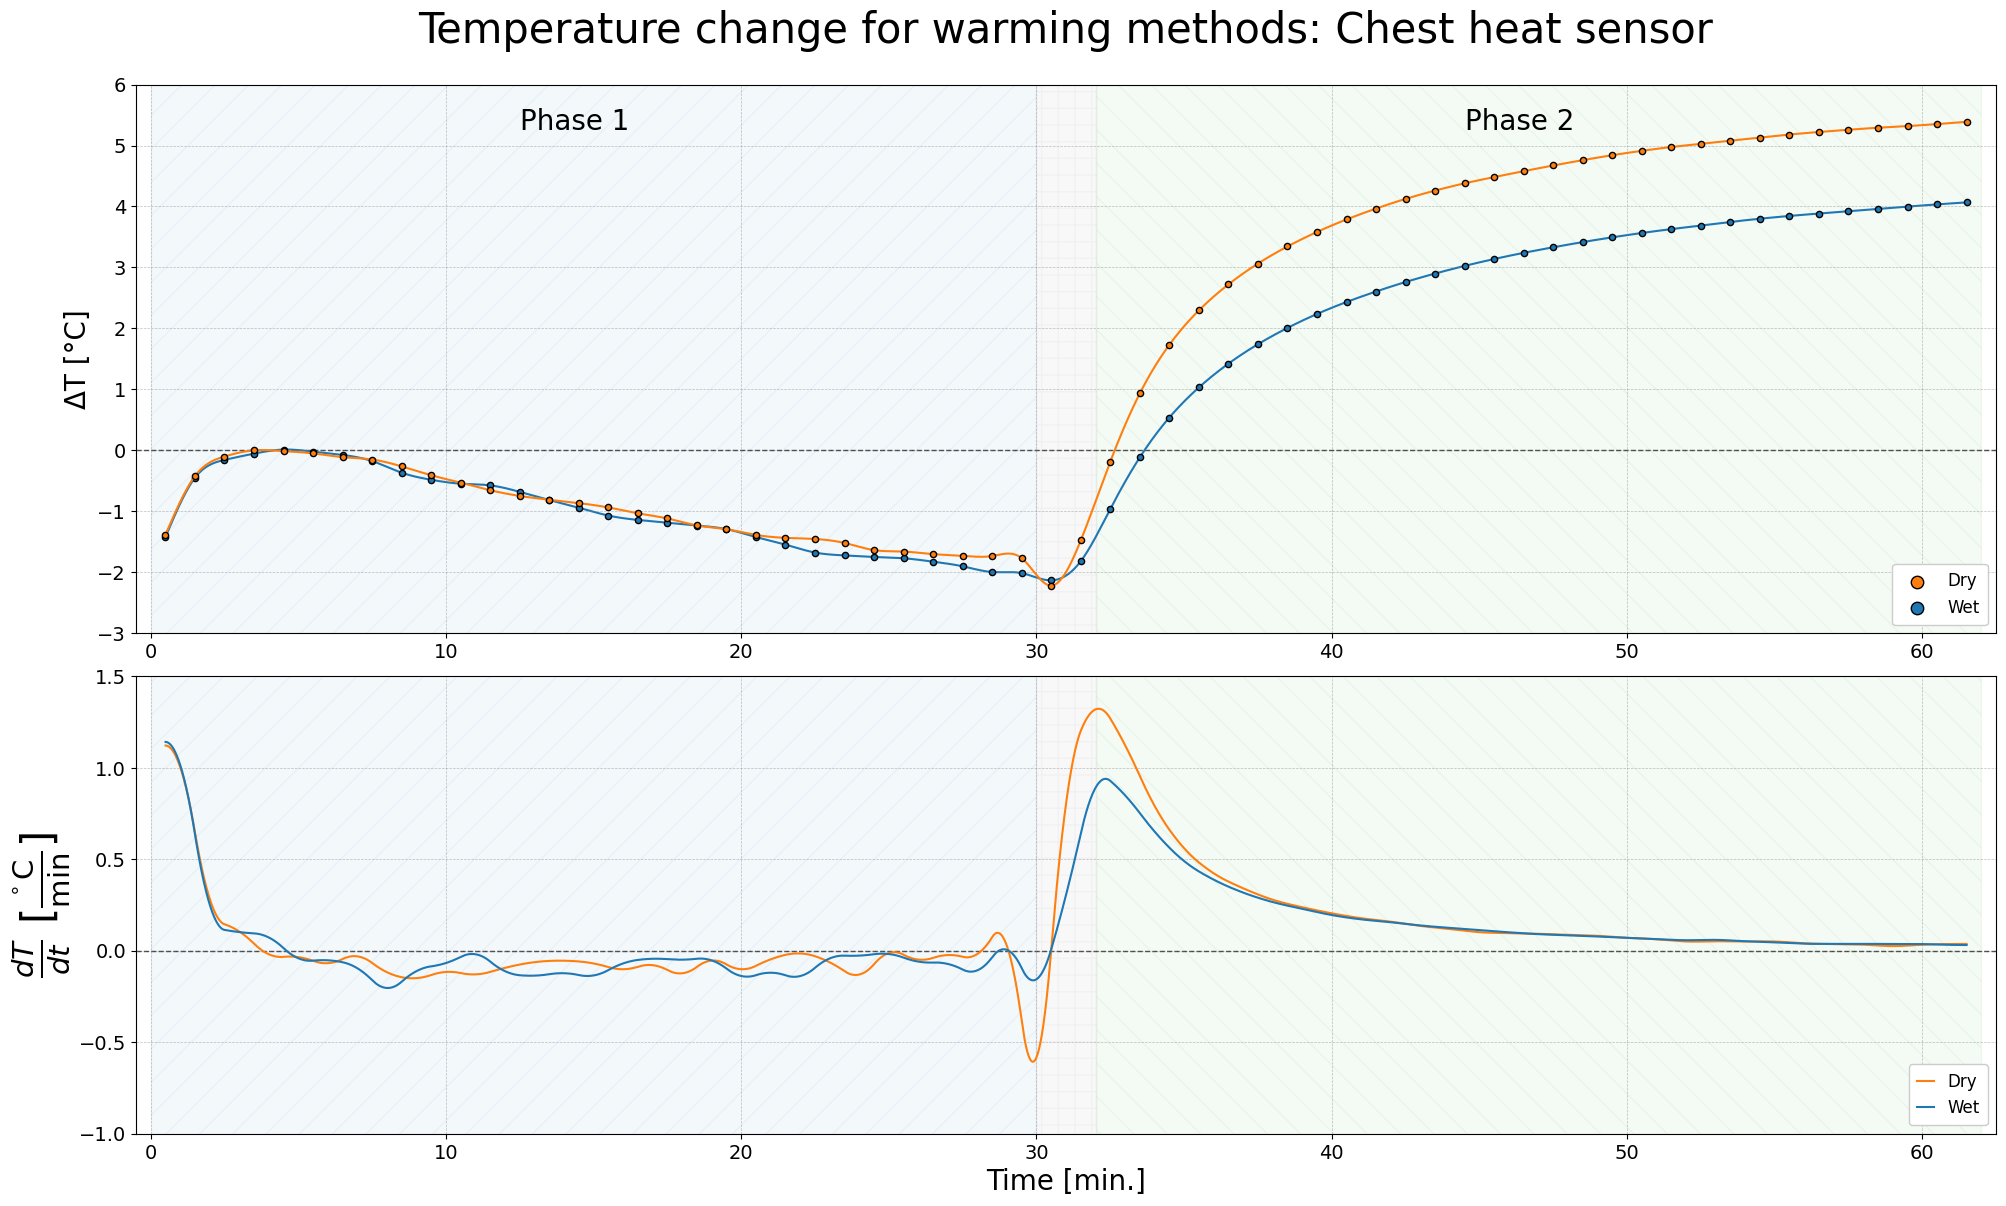

"\nplt.figure(figsize=(12,3))\nplt.title('Mean temperature difference between the groups adjusted for baseline')\nplt.ylim(-0.5, 1.75)\nplt.xlim(-0.5, 62.5)\nplt.xlabel('Time [min.]', fontsize='10')\nplt.ylabel('Temperature difference ΔT [°C]', fontsize='10')\nplt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='gray', axis='both', which='both', zorder=0)\nplt.axvspan(0, 30, color='tab:Blue', alpha=0.05, hatch='/')\nplt.axvspan(30, 32, color='tab:Gray', alpha=0.05, hatch='+')\nplt.axvspan(32, 62, color='tab:Green', alpha=0.05, hatch='\\')\nplt.text(12.5, 1.55, 'Phase 1', fontsize = 'large')\nplt.text(44.5, 1.55, 'Phase 2', fontsize = 'large')\nplt.plot(DC_SI['x_interp'], Dry_Chest_diff, color='Black')\nplt.axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)\nplt.show()\n"

In [5]:
##########   Chest   ##########
Chest_TMP1D = df_1D['Channel 1']
Chest_TMP1W = df_1W['Channel 1']
Chest_TMP2D = df_2D['Channel 1']
Chest_TMP2W = df_2W['Channel 1']
Chest_TMP3D = df_3D['Channel 1']
Chest_TMP3W = df_3W['Channel 1']
Chest_TMP4D = df_4D['Channel 1']
Chest_TMP4W = df_4D['Channel 1']

Chest_min_length = min(len(Chest_TMP1D), len(Chest_TMP1W),
                        len(Chest_TMP2D), len(Chest_TMP3W),
                        len(Chest_TMP3D), len(Chest_TMP3W),
                        len(Chest_TMP4D), len(Chest_TMP4W)
                        )

Timestamps = [i * SamplingRate_minutes for i in range (0, Chest_min_length)]

Chest_TMP1D = Chest_TMP1D[:Chest_min_length]
Chest_TMP1W = Chest_TMP1W[:Chest_min_length]
Chest_TMP2D = Chest_TMP2D[:Chest_min_length]
Chest_TMP2W = Chest_TMP2W[:Chest_min_length]
Chest_TMP3D = Chest_TMP3D[:Chest_min_length]
Chest_TMP3W = Chest_TMP3W[:Chest_min_length]
Chest_TMP4D = Chest_TMP4D[:Chest_min_length]
Chest_TMP4W = Chest_TMP4W[:Chest_min_length]

#Define headers
headers = ['1D','2D','3D','4D','1W','2W','3W','4W']

#Create a dictionaries from the headers and sensor data
Chest_dict = {
    headers[0]: Chest_TMP1D,
    headers[1]: Chest_TMP2D,
    headers[2]: Chest_TMP3D,
    headers[3]: Chest_TMP4D,
    headers[4]: Chest_TMP1W,
    headers[5]: Chest_TMP2W,
    headers[6]: Chest_TMP3W,
    headers[7]: Chest_TMP4W, 
}

##########   List averages   ##########
Dry_Chest_averages = list_averages(min_length=Chest_min_length, dictionary=Chest_dict, headers=headers, start_header=0, end_header=4)
Wet_Chest_averages = list_averages(min_length=Chest_min_length, dictionary=Chest_dict, headers=headers, start_header=4, end_header=8)

##########   Local extrema   ##########
Dry_Chest_results = find_peaks_and_minima(Dry_Chest_averages, Timestamps, h=17.5, prom=2, dist=5000, h_min=-30, prom_min=2, dist_min=5000)
Wet_Chest_results = find_peaks_and_minima(Wet_Chest_averages, Timestamps, h=17.5, prom=2, dist=5000, h_min=-30, prom_min=2, dist_min=5000)

##########   Interval averages   ##########
Timestamps_interval_averages = interval_averages(data=Timestamps)
Dry_Chest_interval_averages = interval_averages(data=Dry_Chest_averages)
Wet_Chest_interval_averages = interval_averages(data=Wet_Chest_averages)

##########   Spline interpolation   ##########
DC_SI = Spline_Interpolation(list_timestamp=Timestamps_interval_averages, data_list=Dry_Chest_interval_averages, data_points=Interpolation_points)
DC_peak_SI = Spline_Interpolation(list_timestamp=Dry_Chest_results['peak_timestamps'], data_list=Dry_Chest_results['peak_temperatures'], data_points=Interpolation_points)
DC_min_SI = Spline_Interpolation(list_timestamp=Dry_Chest_results['minima_timestamps'], data_list=Dry_Chest_results['minima_temperatures'], data_points=Interpolation_points)
WC_SI = Spline_Interpolation(list_timestamp=Timestamps_interval_averages, data_list=Wet_Chest_interval_averages, data_points=Interpolation_points)
WC_peak_SI = Spline_Interpolation(list_timestamp=Wet_Chest_results['peak_timestamps'], data_list=Wet_Chest_results['peak_temperatures'], data_points=Interpolation_points)
WC_min_SI = Spline_Interpolation(list_timestamp=Wet_Chest_results['minima_timestamps'], data_list=Wet_Chest_results['minima_temperatures'], data_points=Interpolation_points)

##########   Temperature difference   ##########
Chest_temp_diff = temp_diff(input_list = Dry_Chest_interval_averages, 
                            list1 = DC_SI['cubicBC'], 
                            list2 = DC_peak_SI['cubicBC'], 
                            list3 = DC_min_SI['cubicBC'], 
                            list4 = Wet_Chest_interval_averages, 
                            list5 = WC_SI['cubicBC'], 
                            list6 = WC_peak_SI['cubicBC'], 
                            list7 = WC_min_SI['cubicBC'] 
                            )

##########   Temperature rate [degree C/s]   ##########
Dry_chest_temperature_rate = temperature_rate(timestamp=DC_SI['x_interp'], data=DC_SI['cubicBC'])
Wet_chest_temperature_rate = temperature_rate(timestamp=WC_SI['x_interp'], data=WC_SI['cubicBC'])

##########   Temperature difference between Dry and Wet group [degree C]   ##########
Dry_Chest_diff = list_difference(data1=Chest_temp_diff[1][1], data2=Chest_temp_diff[1][5])

'''

##########   Plot   ##########
plot_template()
plt.title('Chest temperature')
plt.plot(Timestamps, Dry_Chest_averages, label='Dry', color='tab:Orange', alpha=0.25)
#plt.plot(Timestamps, Wet_Chest_averages, label='Wet', color='tab:Blue', alpha=0.25)
plt.scatter(Dry_Chest_results['peak_timestamps'], Dry_Chest_results['peak_temperatures'], color='tab:Orange', edgecolors='Black', zorder=1)
plt.scatter(Dry_Chest_results['minima_timestamps'], Dry_Chest_results['minima_temperatures'], 
            color='tab:Orange', edgecolors='Black', marker='X', zorder=1)
#plt.scatter(Wet_Chest_results['peak_timestamps'], Wet_Chest_results['peak_temperatures'], color='tab:blue', edgecolors='Black', zorder=2)
#plt.scatter(Wet_Chest_results['minima_timestamps'], Wet_Chest_results['minima_temperatures'], 
            #color='tab:blue', edgecolors='Black', marker='X', zorder=2)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='center right')

plot_template()
plt.title('Chest temperature: Interval averages')
plt.scatter(Timestamps_interval_averages, Dry_Chest_interval_averages, label='Dry', color='tab:Orange', edgecolors='Black', s=20, zorder=4)
plt.plot(DC_SI['x_interp'], DC_SI['cubicBC'], color='tab:Orange', zorder=2)
plt.plot(DC_peak_SI['x_interp'], DC_peak_SI['cubicBC'], color='tab:Orange', linestyle=':', label='Dry peak', alpha=0.5, zorder=0)
plt.plot(DC_min_SI['x_interp'], DC_min_SI['cubicBC'], color='tab:Orange', linestyle=':', label='Dry minima', alpha=0.5, zorder=0)
plt.scatter(Timestamps_interval_averages, Wet_Chest_interval_averages, label='Wet', color='tab:Blue', edgecolors='Black', s=20, zorder=3)
plt.plot(WC_SI['x_interp'], WC_SI['cubicBC'], color='tab:Blue', zorder=1)
plt.plot(WC_peak_SI['x_interp'], WC_peak_SI['cubicBC'], color='tab:Blue', linestyle=':', label='Wet peak', alpha=0.5, zorder=0)
plt.plot(WC_min_SI['x_interp'], WC_min_SI['cubicBC'], color='tab:Blue', linestyle=':', label='Wet minima', alpha=0.5, zorder=0)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='lower right')

plot_template_zoomDiff()
plt.title('Chest temperature difference')
plt.scatter(Timestamps_interval_averages, Chest_temp_diff[1][0], label='Dry', color='tab:Orange', edgecolors='Black', s=20, zorder=5)
plt.plot(DC_SI['x_interp'], Chest_temp_diff[1][1], color='tab:Orange', zorder=3)
plt.plot(DC_peak_SI['x_interp'], Chest_temp_diff[1][2], color='tab:Orange', linestyle=':', label='Dry peak', alpha=0.5, zorder=1)
plt.plot(DC_min_SI['x_interp'], Chest_temp_diff[1][3], color='tab:Orange', linestyle=':', label='Dry minima', alpha=0.5, zorder=1)
plt.scatter(Timestamps_interval_averages, Chest_temp_diff[1][4], label='Wet', color='tab:Blue', edgecolors='Black', s=20, zorder=4)
plt.plot(WC_SI['x_interp'], Chest_temp_diff[1][5], color='tab:Blue', zorder=2)
plt.plot(WC_peak_SI['x_interp'], Chest_temp_diff[1][6], color='tab:Blue', linestyle=':', label='Wet peak', alpha=0.5, zorder=1)
plt.plot(WC_min_SI['x_interp'], Chest_temp_diff[1][7], color='tab:Blue', linestyle=':', label='Wet minima', alpha=0.5, zorder=1)
plt.axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='upper left')

plot_template_rate_min()
plt.title('Chest temperature rate per minute')
plt.plot(Dry_chest_temperature_rate[0], Dry_chest_temperature_rate[1], color='tab:Orange', label='Dry')
plt.plot(Wet_chest_temperature_rate[0], Wet_chest_temperature_rate[1], color='tab:Blue', label='Wet')
plt.axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='best')

plot_template_rate_seconds()
plt.title('Chest temperature rate per second')
plt.plot(Dry_chest_temperature_rate[0], Dry_chest_temperature_rate[2], color='tab:Orange', label='Dry')
plt.plot(Wet_chest_temperature_rate[0], Wet_chest_temperature_rate[2], color='tab:Blue', label='Wet')
plt.axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='best')

'''

#####################################################################################################################

# Create a 1x2 grid of subplots
fig, ax = plt.subplots(2, 1, figsize=(20, 12),height_ratios=[3, 2.5])
# First subplot for Dry data
ax[0].set_ylim(-3, 6)
ax[0].set_xlim(-0.5, 62.5)
#ax[0].set_xlabel('Time [min.]', fontsize='20')
ax[0].set_ylabel('\u0394T [\u00b0C]', fontsize='20')
ax[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='gray', axis='both', which='both', zorder=0)
ax[0].axvspan(0, 30, color='tab:Blue', alpha=0.05, hatch='/')
ax[0].axvspan(30, 32, color='tab:Gray', alpha=0.05, hatch='+')
ax[0].axvspan(32, 62, color='tab:Green', alpha=0.05, hatch='\\')
ax[0].text(12.5, 5.25, 'Phase 1', fontsize='20', bbox=dict(facecolor='none', edgecolor='none'))
ax[0].text(44.5, 5.25, 'Phase 2', fontsize='20', bbox=dict(facecolor='none', edgecolor='none'))
ax[0].tick_params(axis='both', which='both', labelsize=14)  # Set the font size for both axes
ax[0].axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)

ax[0].set_title('Temperature change for warming methods: Chest heat sensor', fontsize='30', fontweight='light', pad=30)
ax[0].scatter(Timestamps_interval_averages, Chest_temp_diff[1][0], label='Dry', color='tab:Orange', edgecolors='Black', s=20, zorder=4)
ax[0].plot(DC_SI['x_interp'], Chest_temp_diff[1][1], color='tab:Orange', zorder=3)
ax[0].scatter(Timestamps_interval_averages, Chest_temp_diff[1][4], label='Wet', color='tab:Blue', edgecolors='Black', s=20, zorder=2)
ax[0].plot(WC_SI['x_interp'], Chest_temp_diff[1][5], color='tab:Blue', zorder=1)
ax[0].legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='lower right',
             fontsize='large', title_fontsize='x-large', borderpad=0.5, labelspacing=0.5, markerscale=2)

# Second subplot for Wet data
ax[1].set_ylim(-1, 1.5)
ax[1].set_xlim(-0.5, 62.5)
#ax[1].set_xlabel('Time [min.]', fontsize='20')
#ax[1].set_ylabel('$\\dot{T}$ [\u00b0C/min]', fontsize='20')
ax[1].set_ylabel(r'$\frac{dT}{dt}$ [$\frac{{}^\circ\mathrm{C}}{\text{min}}$]', fontsize='30')
ax[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='gray', axis='both', which='both', zorder=0)
ax[1].axvspan(0, 30, color='tab:Blue', alpha=0.05, hatch='/')
ax[1].axvspan(30, 32, color='tab:Gray', alpha=0.05, hatch='+')
ax[1].axvspan(32, 62, color='tab:Green', alpha=0.05, hatch='\\')
#ax[1].text(12.5, 1.25, 'Phase 1', fontsize='20', bbox=dict(facecolor='none', edgecolor='none'))
#ax[1].text(44.5, 1.25, 'Phase 2', fontsize='20', bbox=dict(facecolor='none', edgecolor='none'))
ax[1].tick_params(axis='both', which='both', labelsize=14)  # Set the font size for both axes
ax[1].axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)
ax[1].plot(Dry_chest_temperature_rate[0], Dry_chest_temperature_rate[1], color='tab:Orange', label='Dry')
ax[1].plot(Wet_chest_temperature_rate[0], Wet_chest_temperature_rate[1], color='tab:Blue', label='Wet')
ax[1].legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='lower right',
             fontsize='large', title_fontsize='x-large', borderpad=0.5, labelspacing=0.5, handlelength=1)
ax[1].set_xlabel('Time [min.]', fontsize='20')


'''
ax[2].set_ylim(-0.5, 1.75)
ax[2].set_xlim(-0.5, 62.5)
ax[2].set_xlabel('Time [min.]', fontsize='20')
ax[2].set_ylabel('\u0394T [\u00b0C]', fontsize='20')
ax[2].grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='gray', axis='both', which='both', zorder=0)
ax[2].axvspan(0, 30, color='tab:Blue', alpha=0.05, hatch='/')
ax[2].axvspan(30, 32, color='tab:Gray', alpha=0.05, hatch='+')
ax[2].axvspan(32, 62, color='tab:Green', alpha=0.05, hatch='\\')
ax[2].tick_params(axis='both', which='both', labelsize=14)  # Set the font size for both axes
ax[2].plot(DC_SI['x_interp'], Dry_Chest_diff, color='Black')
ax[2].axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)
'''
# Improve layout and display the plot
plt.tight_layout(pad=0.5)  # Automatically adjust with padding
plt.show()

'''
plt.figure(figsize=(12,3))
plt.title('Mean temperature difference between the groups adjusted for baseline')
plt.ylim(-0.5, 1.75)
plt.xlim(-0.5, 62.5)
plt.xlabel('Time [min.]', fontsize='10')
plt.ylabel('Temperature difference \u0394T [\u00b0C]', fontsize='10')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='gray', axis='both', which='both', zorder=0)
plt.axvspan(0, 30, color='tab:Blue', alpha=0.05, hatch='/')
plt.axvspan(30, 32, color='tab:Gray', alpha=0.05, hatch='+')
plt.axvspan(32, 62, color='tab:Green', alpha=0.05, hatch='\\')
plt.text(12.5, 1.55, 'Phase 1', fontsize = 'large')
plt.text(44.5, 1.55, 'Phase 2', fontsize = 'large')
plt.plot(DC_SI['x_interp'], Dry_Chest_diff, color='Black')
plt.axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)
plt.show()
'''

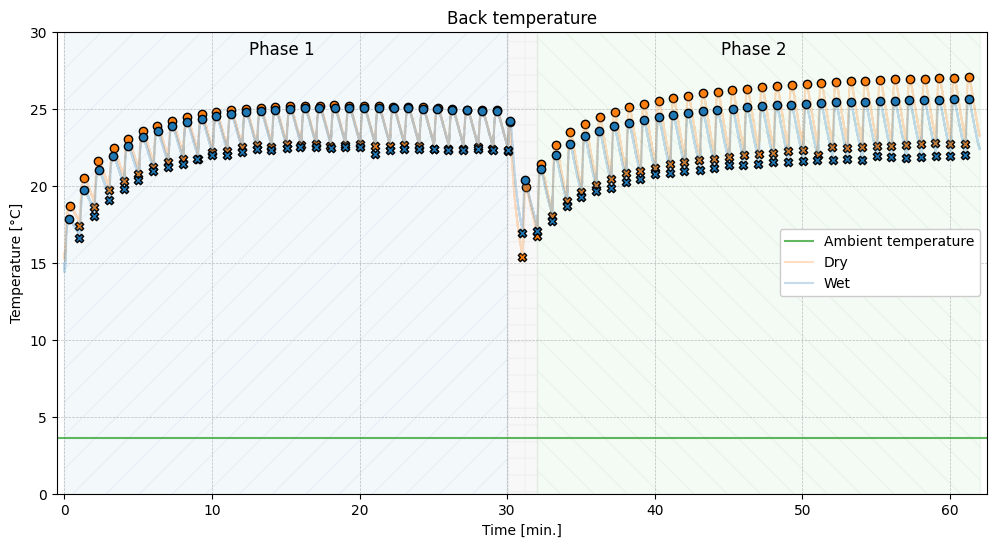

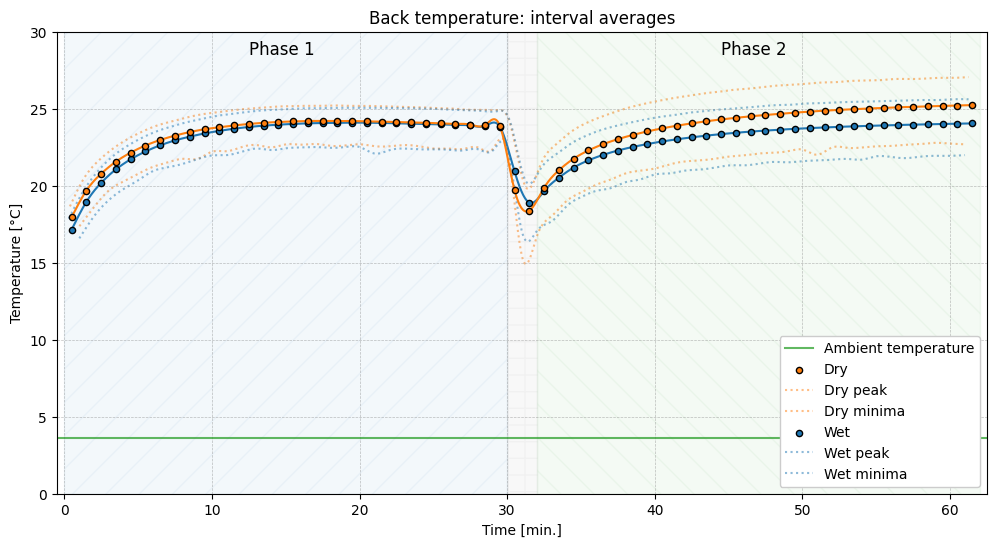

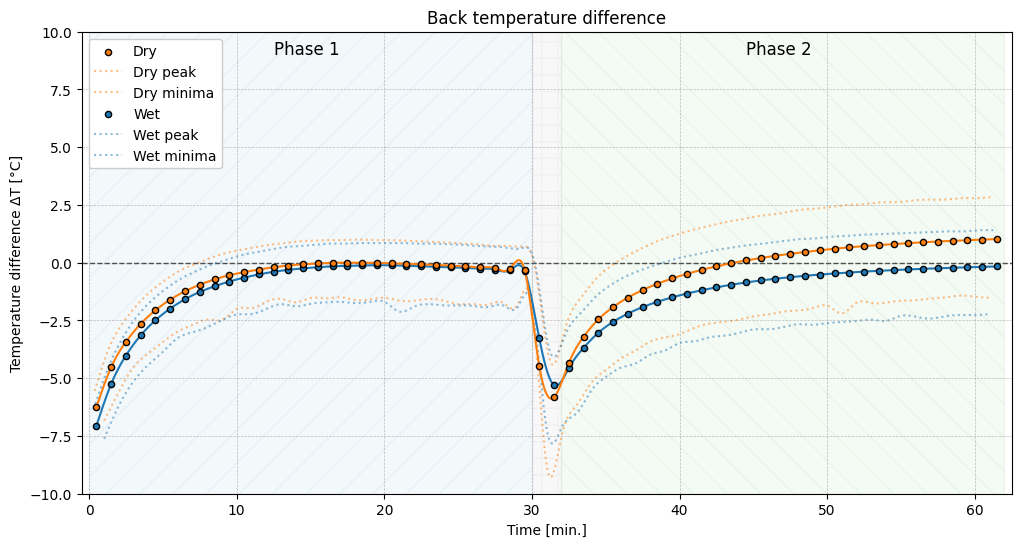

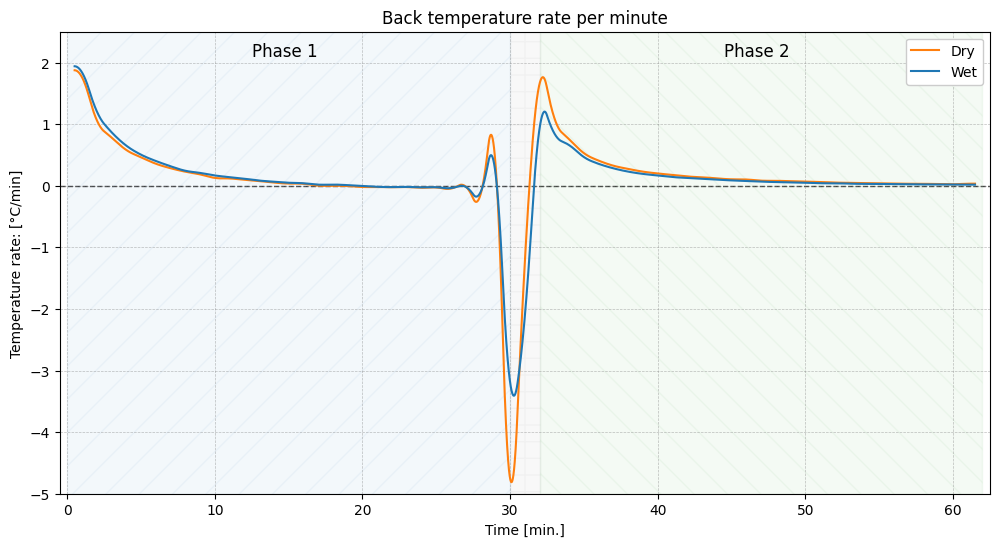

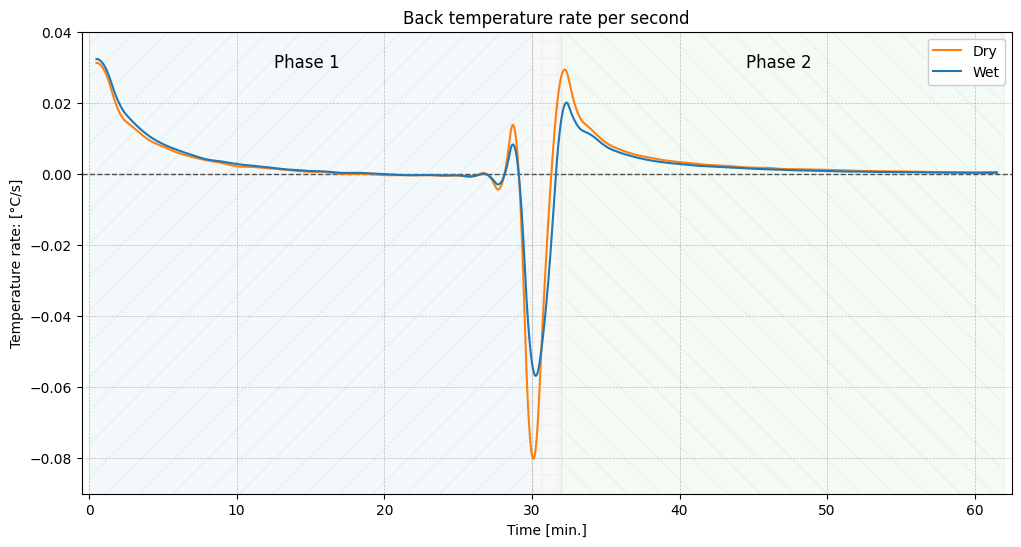

In [6]:
##########   Back   ##########

Back_TMP1D = df_1D['Channel 2']
Back_TMP1W = df_1W['Channel 2']
Back_TMP2D = df_2D['Channel 2']
Back_TMP2W = df_2W['Channel 2']
Back_TMP3D = df_3D['Channel 2']
Back_TMP3W = df_3W['Channel 2']
Back_TMP4D = df_4D['Channel 2']
Back_TMP4W = df_4D['Channel 2']

Back_min_length = min(len(Back_TMP1D), len(Back_TMP1W),
                      len(Back_TMP2D), len(Back_TMP3W),
                      len(Back_TMP3D), len(Back_TMP3W),
                      len(Back_TMP4D), len(Back_TMP4W)
                      )


Back_TMP1D = Back_TMP1D[:Back_min_length]
Back_TMP1W = Back_TMP1W[:Back_min_length]
Back_TMP2D = Back_TMP2D[:Back_min_length]
Back_TMP2W = Back_TMP2W[:Back_min_length]
Back_TMP3D = Back_TMP3D[:Back_min_length]
Back_TMP3W = Back_TMP3W[:Back_min_length]
Back_TMP4D = Back_TMP4D[:Back_min_length]
Back_TMP4W = Back_TMP4W[:Back_min_length]

#Define headers
headers = ['1D','2D','3D','4D','1W','2W','3W','4W']

#Create a dictionaries from the headers and sensor data
Back_dict = {
    headers[0]: Back_TMP1D,
    headers[1]: Back_TMP2D,
    headers[2]: Back_TMP3D,
    headers[3]: Back_TMP4D,
    headers[4]: Back_TMP1W,
    headers[5]: Back_TMP2W,
    headers[6]: Back_TMP3W,
    headers[7]: Back_TMP4W, 
}

##########   List averages   ##########
Dry_Back_averages = list_averages(min_length=Back_min_length, dictionary=Back_dict, headers=headers, start_header=0, end_header=4)
Wet_Back_averages = list_averages(min_length=Back_min_length, dictionary=Back_dict, headers=headers, start_header=4, end_header=8)

##########   Local extrema   ##########
Dry_Back_results = find_peaks_and_minima(Dry_Back_averages, Timestamps, h=17.5, prom=1, dist=5000, h_min=-30, prom_min=1, dist_min=5000)
Wet_Back_results = find_peaks_and_minima(Wet_Back_averages, Timestamps, h=17.5, prom=1, dist=5000, h_min=-30, prom_min=1, dist_min=5000)

##########   Interval averages   ##########
Dry_Back_interval_averages = interval_averages(data=Dry_Back_averages)
Wet_Back_interval_averages = interval_averages(data=Wet_Back_averages)

##########   Spline interpolation   ##########
    #Dry
DB_SI = Spline_Interpolation(list_timestamp=Timestamps_interval_averages, data_list=Dry_Back_interval_averages, data_points=Interpolation_points)
DB_peak_SI = Spline_Interpolation(list_timestamp=Dry_Back_results['peak_timestamps'], data_list=Dry_Back_results['peak_temperatures'], data_points=Interpolation_points)
DB_min_SI = Spline_Interpolation(list_timestamp=Dry_Back_results['minima_timestamps'], data_list=Dry_Back_results['minima_temperatures'], data_points=Interpolation_points)
    #Wet
WB_SI = Spline_Interpolation(list_timestamp=Timestamps_interval_averages, data_list=Wet_Back_interval_averages, data_points=Interpolation_points)
WB_peak_SI = Spline_Interpolation(list_timestamp=Wet_Back_results['peak_timestamps'], data_list=Wet_Back_results['peak_temperatures'], data_points=Interpolation_points)
WB_min_SI = Spline_Interpolation(list_timestamp=Wet_Back_results['minima_timestamps'], data_list=Wet_Back_results['minima_temperatures'], data_points=Interpolation_points)

##########   Temperature difference   ##########
Back_temp_diff = temp_diff(input_list = Dry_Back_interval_averages, 
                            list1 = DB_SI['cubicBC'], 
                            list2 = DB_peak_SI['cubicBC'], 
                            list3 = DB_min_SI['cubicBC'], 
                            list4 = Wet_Back_interval_averages, 
                            list5 = WB_SI['cubicBC'], 
                            list6 = WB_peak_SI['cubicBC'], 
                            list7 = WB_min_SI['cubicBC'] 
                            )

##########   Temperature rate [degree C/s]   ##########
Dry_back_temperature_rate = temperature_rate(timestamp=DB_SI['x_interp'], data=DB_SI['cubicBC'])
Wet_back_temperature_rate = temperature_rate(timestamp=WB_SI['x_interp'], data=WB_SI['cubicBC'])

##########   Plot   ##########
plot_template()
plt.title('Back temperature')
plt.plot(Timestamps, Dry_Back_averages, label='Dry', color='tab:orange', alpha=0.25)
plt.plot(Timestamps, Wet_Back_averages, label='Wet', color='tab:blue', alpha=0.25)
plt.scatter(Dry_Back_results['peak_timestamps'], Dry_Back_results['peak_temperatures'], color='tab:Orange', edgecolors='Black', zorder=1)
plt.scatter(Dry_Back_results['minima_timestamps'], Dry_Back_results['minima_temperatures'], 
            color='tab:Orange', edgecolors='Black', marker='X', zorder=1)
plt.scatter(Wet_Back_results['peak_timestamps'], Wet_Back_results['peak_temperatures'], color='tab:blue', edgecolors='Black', zorder=2)
plt.scatter(Wet_Back_results['minima_timestamps'], Wet_Back_results['minima_temperatures'], 
            color='tab:blue', edgecolors='Black', marker='X', zorder=2)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='center right')

plot_template()
plt.title('Back temperature: interval averages')
plt.scatter(Timestamps_interval_averages, Dry_Back_interval_averages, label='Dry', color='tab:Orange', edgecolors='Black', s=20, zorder=4)
plt.plot(DB_SI['x_interp'], DB_SI['cubicBC'], color='tab:Orange', zorder=2)
plt.plot(DB_peak_SI['x_interp'], DB_peak_SI['cubicBC'], color='tab:Orange', linestyle=':', label='Dry peak', alpha=0.5, zorder=0)
plt.plot(DB_min_SI['x_interp'], DB_min_SI['cubicBC'], color='tab:Orange', linestyle=':', label='Dry minima', alpha=0.5, zorder=0)
plt.scatter(Timestamps_interval_averages, Wet_Back_interval_averages, label='Wet', color='tab:Blue', edgecolors='Black', s=20, zorder=3)
plt.plot(WB_SI['x_interp'], WB_SI['cubicBC'], color='tab:Blue', zorder=1)
plt.plot(WB_peak_SI['x_interp'], WB_peak_SI['cubicBC'], color='tab:Blue', linestyle=':', label='Wet peak', alpha=0.5, zorder=0)
plt.plot(WB_min_SI['x_interp'], WB_min_SI['cubicBC'], color='tab:Blue', linestyle=':', label='Wet minima', alpha=0.5, zorder=0)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='lower right')

plot_template_zoomDiff()
plt.title('Back temperature difference')
plt.scatter(Timestamps_interval_averages, Back_temp_diff[1][0], label='Dry', color='tab:Orange', edgecolors='Black', s=20, zorder=5)
plt.plot(DB_SI['x_interp'], Back_temp_diff[1][1], color='tab:Orange', zorder=3)
plt.plot(DB_peak_SI['x_interp'], Back_temp_diff[1][2], color='tab:Orange', linestyle=':', label='Dry peak', alpha=0.5, zorder=1)
plt.plot(DB_min_SI['x_interp'], Back_temp_diff[1][3], color='tab:Orange', linestyle=':', label='Dry minima', alpha=0.5, zorder=1)
plt.scatter(Timestamps_interval_averages, Back_temp_diff[1][4], label='Wet', color='tab:Blue', edgecolors='Black', s=20, zorder=4)
plt.plot(WB_SI['x_interp'], Back_temp_diff[1][5], color='tab:Blue', zorder=2)
plt.plot(WB_peak_SI['x_interp'], Back_temp_diff[1][6], color='tab:Blue', linestyle=':', label='Wet peak', alpha=0.5, zorder=1)
plt.plot(WB_min_SI['x_interp'], Back_temp_diff[1][7], color='tab:Blue', linestyle=':', label='Wet minima', alpha=0.5, zorder=1)
plt.axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='upper left')

plot_template_rate_min()
plt.title('Back temperature rate per minute')
plt.plot(Dry_back_temperature_rate[0], Dry_back_temperature_rate[1], color='tab:Orange', label='Dry')
plt.plot(Wet_back_temperature_rate[0], Wet_back_temperature_rate[1], color='tab:Blue', label='Wet')
plt.axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='best')

plot_template_rate_seconds()
plt.title('Back temperature rate per second')
plt.plot(Dry_back_temperature_rate[0], Dry_back_temperature_rate[2], color='tab:Orange', label='Dry')
plt.plot(Wet_back_temperature_rate[0], Wet_back_temperature_rate[2], color='tab:Blue', label='Wet')
plt.axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='best')

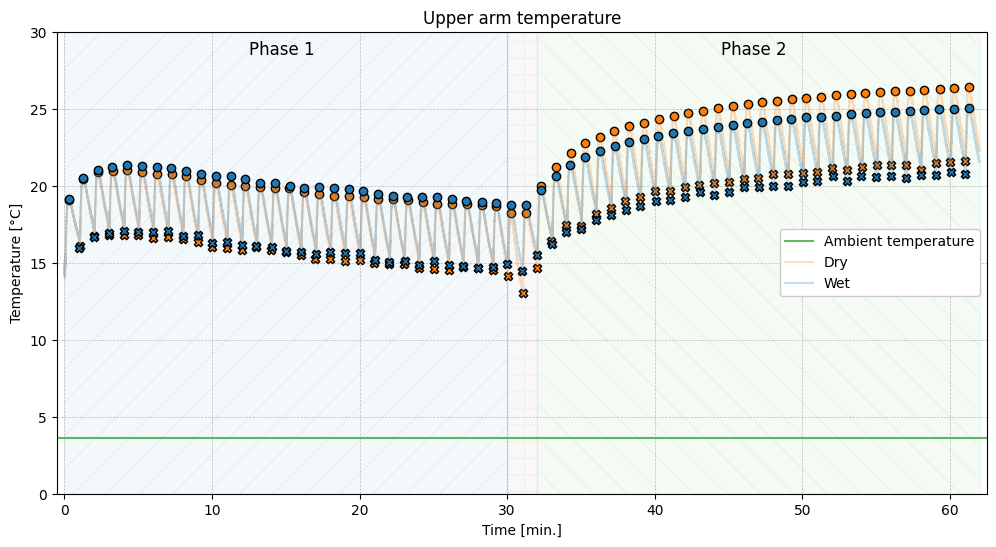

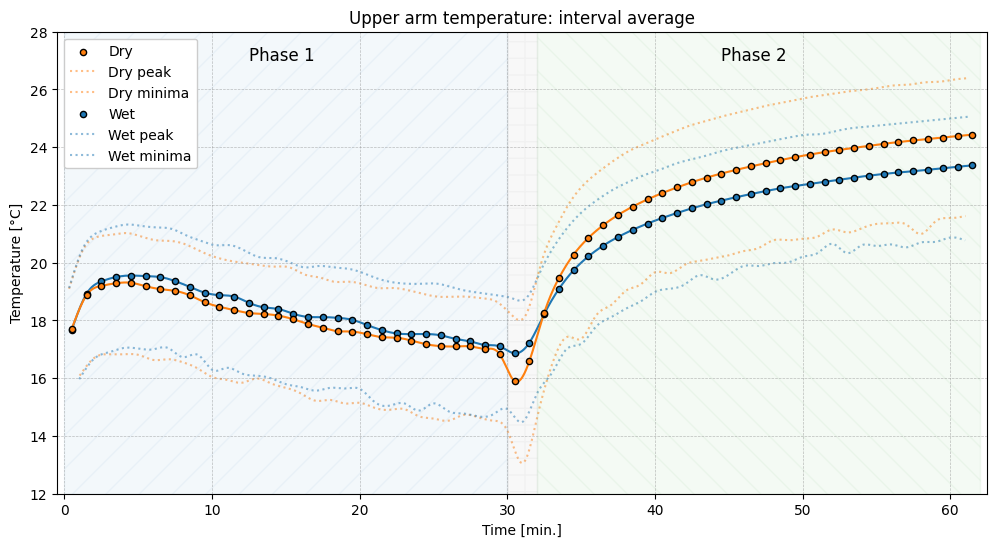

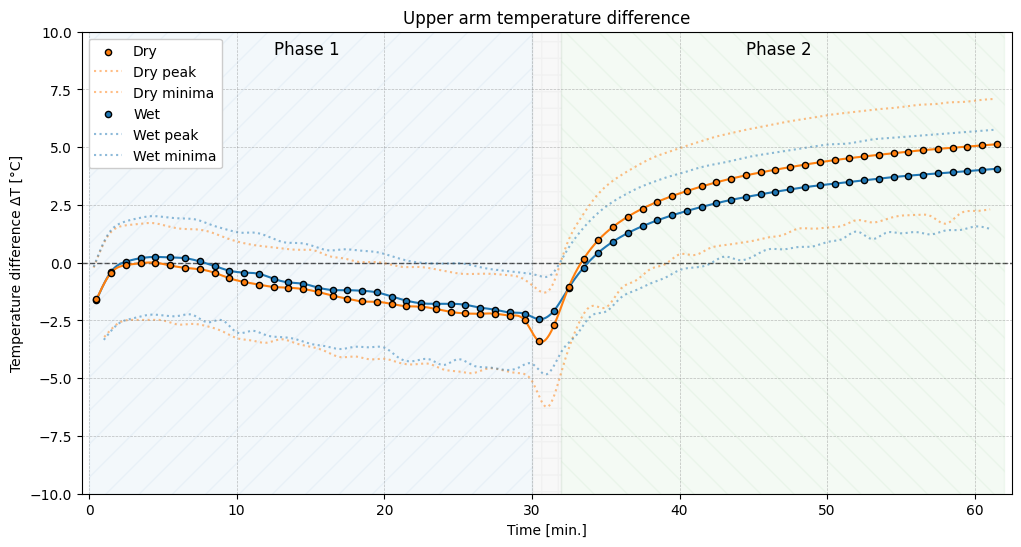

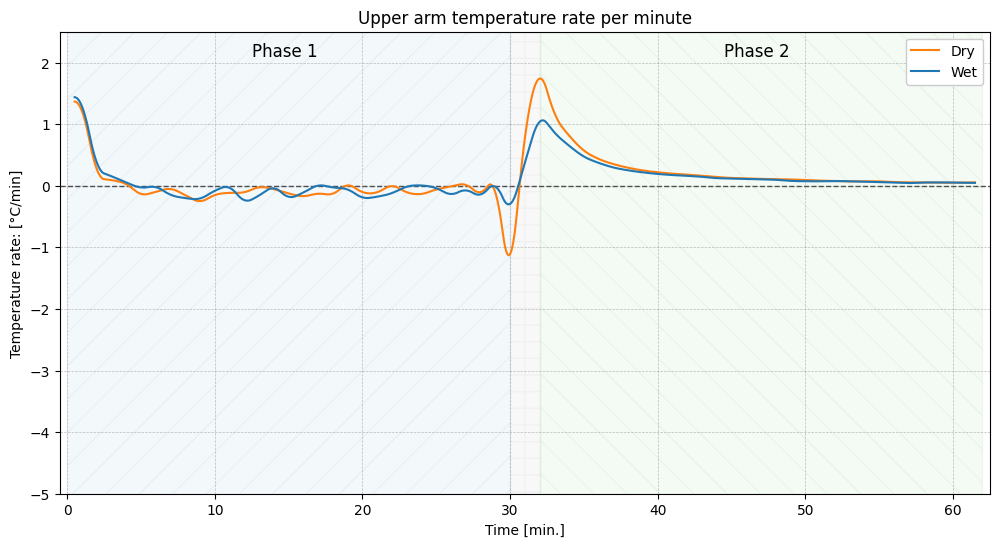

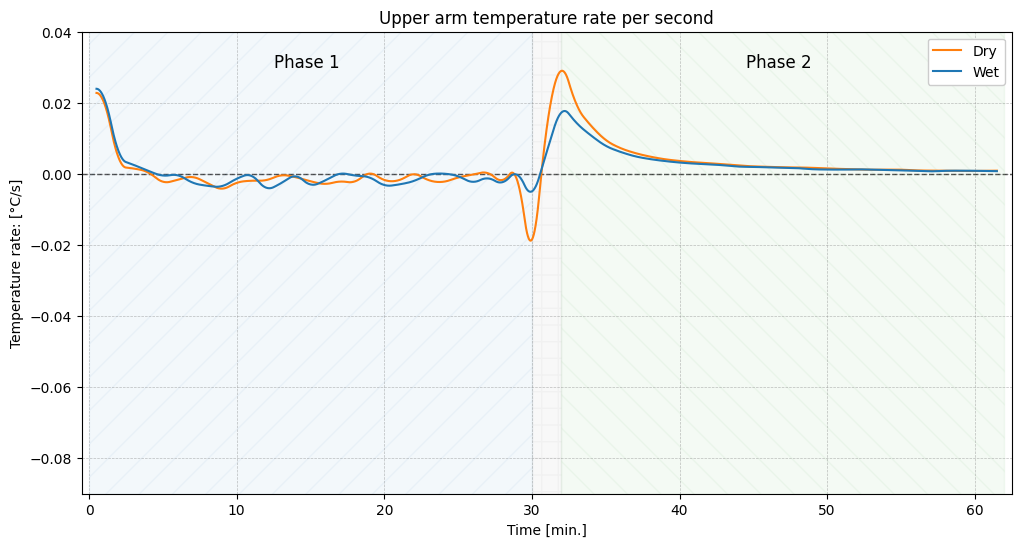

In [7]:
##########   Upper arm   ##########

Uarm_TMP1D = df_1D['Channel 3']
Uarm_TMP1W = df_1W['Channel 3']
Uarm_TMP2D = df_2D['Channel 3']
Uarm_TMP2W = df_2W['Channel 3']
Uarm_TMP3D = df_3D['Channel 3']
Uarm_TMP3W = df_3W['Channel 3']
Uarm_TMP4D = df_4D['Channel 3']
Uarm_TMP4W = df_4D['Channel 3']

Uarm_min_length = min(len(Uarm_TMP1D), len(Uarm_TMP1W),
                      len(Uarm_TMP2D), len(Uarm_TMP3W),
                      len(Uarm_TMP3D), len(Uarm_TMP3W),
                      len(Uarm_TMP4D), len(Uarm_TMP4W)
                      )


Uarm_TMP1D = Uarm_TMP1D[:Uarm_min_length]
Uarm_TMP1W = Uarm_TMP1W[:Uarm_min_length]
Uarm_TMP2D = Uarm_TMP2D[:Uarm_min_length]
Uarm_TMP2W = Uarm_TMP2W[:Uarm_min_length]
Uarm_TMP3D = Uarm_TMP3D[:Uarm_min_length]
Uarm_TMP3W = Uarm_TMP3W[:Uarm_min_length]
Uarm_TMP4D = Uarm_TMP4D[:Uarm_min_length]
Uarm_TMP4W = Uarm_TMP4W[:Uarm_min_length]

#Define headers
headers = ['1D','2D','3D','4D','1W','2W','3W','4W']

#Create a dictionaries from the headers and sensor data
Uarm_dict = {
    headers[0]: Uarm_TMP1D,
    headers[1]: Uarm_TMP2D,
    headers[2]: Uarm_TMP3D,
    headers[3]: Uarm_TMP4D,
    headers[4]: Uarm_TMP1W,
    headers[5]: Uarm_TMP2W,
    headers[6]: Uarm_TMP3W,
    headers[7]: Uarm_TMP4W, 
}

##########   List averages   ##########
Dry_Uarm_averages = list_averages(min_length=Uarm_min_length, dictionary=Uarm_dict, headers=headers, start_header=0, end_header=4)
Wet_Uarm_averages = list_averages(min_length=Uarm_min_length, dictionary=Uarm_dict, headers=headers, start_header=4, end_header=8)

##########   Local extrema   ##########
Dry_Uarm_results = find_peaks_and_minima(Dry_Uarm_averages, Timestamps, h=17.5, prom=2, dist=5000, h_min=-30, prom_min=2, dist_min=5000)
Wet_Uarm_results = find_peaks_and_minima(Wet_Uarm_averages, Timestamps, h=17.5, prom=2, dist=5000, h_min=-30, prom_min=2, dist_min=5000)

##########   Interval averages   ##########
Dry_Uarm_interval_averages = interval_averages(data=Dry_Uarm_averages)
Wet_Uarm_interval_averages = interval_averages(data=Wet_Uarm_averages)

##########   Spline interpolation   ##########
DUa_SI = Spline_Interpolation(list_timestamp=Timestamps_interval_averages, data_list=Dry_Uarm_interval_averages, data_points=Interpolation_points)
DUa_peak_SI = Spline_Interpolation(list_timestamp=Dry_Uarm_results['peak_timestamps'], data_list=Dry_Uarm_results['peak_temperatures'], data_points=Interpolation_points)
DUa_min_SI = Spline_Interpolation(list_timestamp=Dry_Uarm_results['minima_timestamps'], data_list=Dry_Uarm_results['minima_temperatures'], data_points=Interpolation_points)
WUa_SI = Spline_Interpolation(list_timestamp=Timestamps_interval_averages, data_list=Wet_Uarm_interval_averages, data_points=Interpolation_points)
WUa_peak_SI = Spline_Interpolation(list_timestamp=Wet_Uarm_results['peak_timestamps'], data_list=Wet_Uarm_results['peak_temperatures'], data_points=Interpolation_points)
WUa_min_SI = Spline_Interpolation(list_timestamp=Wet_Uarm_results['minima_timestamps'], data_list=Wet_Uarm_results['minima_temperatures'], data_points=Interpolation_points)

##########   Temperature difference   ##########
Uarm_temp_diff = temp_diff(input_list = Dry_Uarm_interval_averages, 
                            list1 = DUa_SI['cubicBC'], 
                            list2 = DUa_peak_SI['cubicBC'], 
                            list3 = DUa_min_SI['cubicBC'], 
                            list4 = Wet_Uarm_interval_averages, 
                            list5 = WUa_SI['cubicBC'], 
                            list6 = WUa_peak_SI['cubicBC'], 
                            list7 = WUa_min_SI['cubicBC'] 
                            )

##########   Temperature rate [degree C/s]   ##########
Dry_Uarm_temperature_rate = temperature_rate(timestamp=DUa_SI['x_interp'], data=DUa_SI['cubicBC'])
Wet_Uarm_temperature_rate = temperature_rate(timestamp=WUa_SI['x_interp'], data=WUa_SI['cubicBC'])

##########   Plot   ##########
plot_template()
plt.title('Upper arm temperature')
plt.plot(Timestamps, Dry_Uarm_averages, label='Dry', color='tab:orange', alpha=0.25)
plt.plot(Timestamps, Wet_Uarm_averages, label='Wet', color='tab:blue', alpha=0.25)
plt.scatter(Dry_Uarm_results['peak_timestamps'], Dry_Uarm_results['peak_temperatures'], color='tab:Orange', edgecolors='Black', zorder=1)
plt.scatter(Dry_Uarm_results['minima_timestamps'], Dry_Uarm_results['minima_temperatures'], 
            color='tab:Orange', edgecolors='Black', marker='X', zorder=1)
plt.scatter(Wet_Uarm_results['peak_timestamps'], Wet_Uarm_results['peak_temperatures'], color='tab:blue', edgecolors='Black', zorder=2)
plt.scatter(Wet_Uarm_results['minima_timestamps'], Wet_Uarm_results['minima_temperatures'], 
            color='tab:blue', edgecolors='Black', marker='X', zorder=2)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='center right')

plot_template_zoom()
plt.title('Upper arm temperature: interval average')
plt.scatter(Timestamps_interval_averages, Dry_Uarm_interval_averages, label='Dry', color='tab:Orange', edgecolors='Black', s=20, zorder=4)
plt.plot(DUa_SI['x_interp'], DUa_SI['cubicBC'], color='tab:Orange', zorder=2)
plt.plot(DUa_peak_SI['x_interp'], DUa_peak_SI['cubicBC'], color='tab:Orange', linestyle=':', label='Dry peak', alpha=0.5, zorder=0)
plt.plot(DUa_min_SI['x_interp'], DUa_min_SI['cubicBC'], color='tab:Orange', linestyle=':', label='Dry minima', alpha=0.5, zorder=0)
plt.scatter(Timestamps_interval_averages, Wet_Uarm_interval_averages, label='Wet', color='tab:Blue', edgecolors='Black', s=20, zorder=3)
plt.plot(WUa_SI['x_interp'], WUa_SI['cubicBC'], color='tab:Blue', zorder=1)
plt.plot(WUa_peak_SI['x_interp'], WUa_peak_SI['cubicBC'], color='tab:Blue', linestyle=':', label='Wet peak', alpha=0.5, zorder=0)
plt.plot(WUa_min_SI['x_interp'], WUa_min_SI['cubicBC'], color='tab:Blue', linestyle=':', label='Wet minima', alpha=0.5, zorder=0)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='upper left')

plot_template_zoomDiff()
plt.title('Upper arm temperature difference')
plt.scatter(Timestamps_interval_averages, Uarm_temp_diff[1][0], label='Dry', color='tab:Orange', edgecolors='Black', s=20, zorder=5)
plt.plot(DUa_SI['x_interp'], Uarm_temp_diff[1][1], color='tab:Orange', zorder=3)
plt.plot(DUa_peak_SI['x_interp'], Uarm_temp_diff[1][2], color='tab:Orange', linestyle=':', label='Dry peak', alpha=0.5, zorder=1)
plt.plot(DUa_min_SI['x_interp'], Uarm_temp_diff[1][3], color='tab:Orange', linestyle=':', label='Dry minima', alpha=0.5, zorder=1)
plt.scatter(Timestamps_interval_averages, Uarm_temp_diff[1][4], label='Wet', color='tab:Blue', edgecolors='Black', s=20, zorder=4)
plt.plot(WUa_SI['x_interp'], Uarm_temp_diff[1][5], color='tab:Blue', zorder=2)
plt.plot(WUa_peak_SI['x_interp'], Uarm_temp_diff[1][6], color='tab:Blue', linestyle=':', label='Wet peak', alpha=0.5, zorder=1)
plt.plot(WUa_min_SI['x_interp'], Uarm_temp_diff[1][7], color='tab:Blue', linestyle=':', label='Wet minima', alpha=0.5, zorder=1)
plt.axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='upper left')

plot_template_rate_min()
plt.title('Upper arm temperature rate per minute')
plt.plot(Dry_Uarm_temperature_rate[0], Dry_Uarm_temperature_rate[1], color='tab:Orange', label='Dry')
plt.plot(Wet_Uarm_temperature_rate[0], Wet_Uarm_temperature_rate[1], color='tab:Blue', label='Wet')
plt.axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='best')

plot_template_rate_seconds()
plt.title('Upper arm temperature rate per second')
plt.plot(Dry_Uarm_temperature_rate[0], Dry_Uarm_temperature_rate[2], color='tab:Orange', label='Dry')
plt.plot(Wet_Uarm_temperature_rate[0], Wet_Uarm_temperature_rate[2], color='tab:Blue', label='Wet')
plt.axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='best')

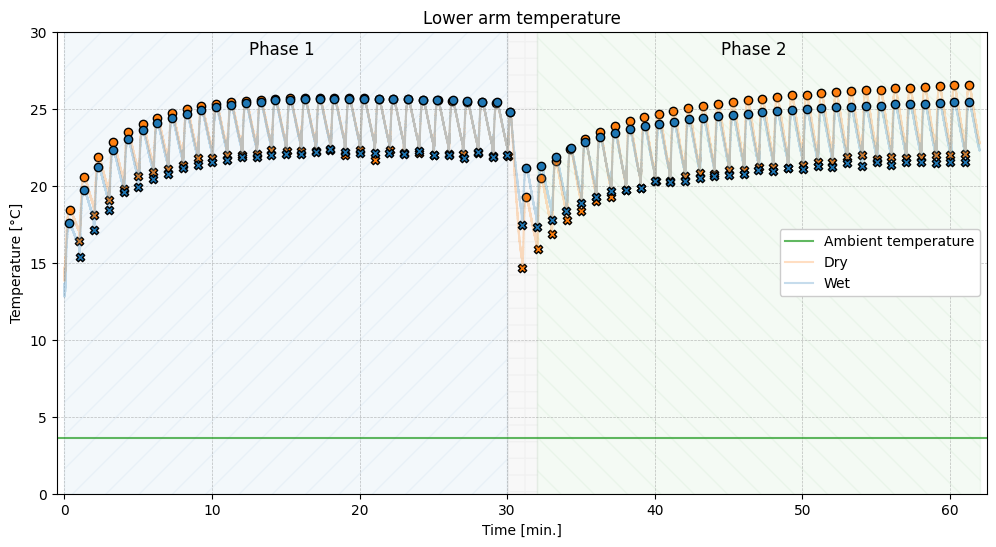

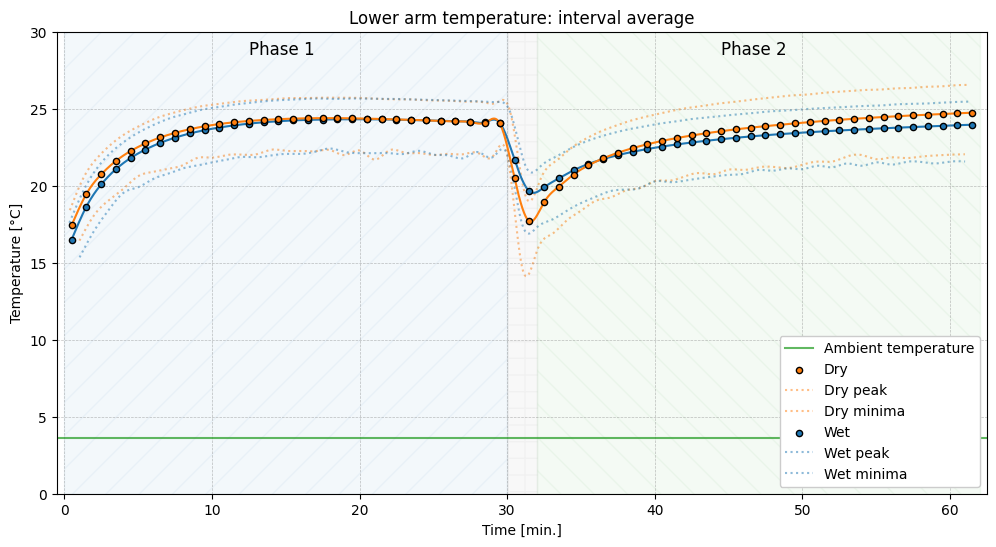

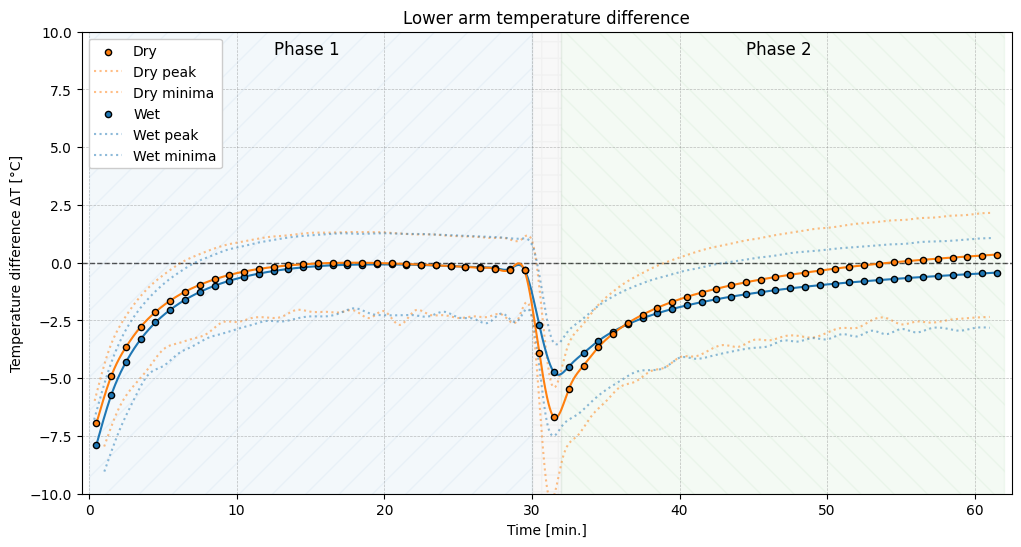

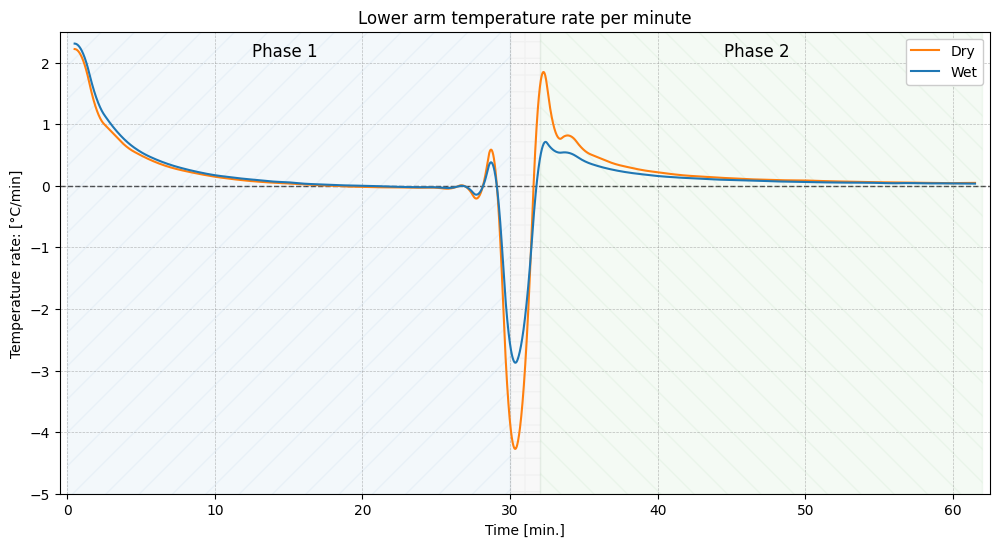

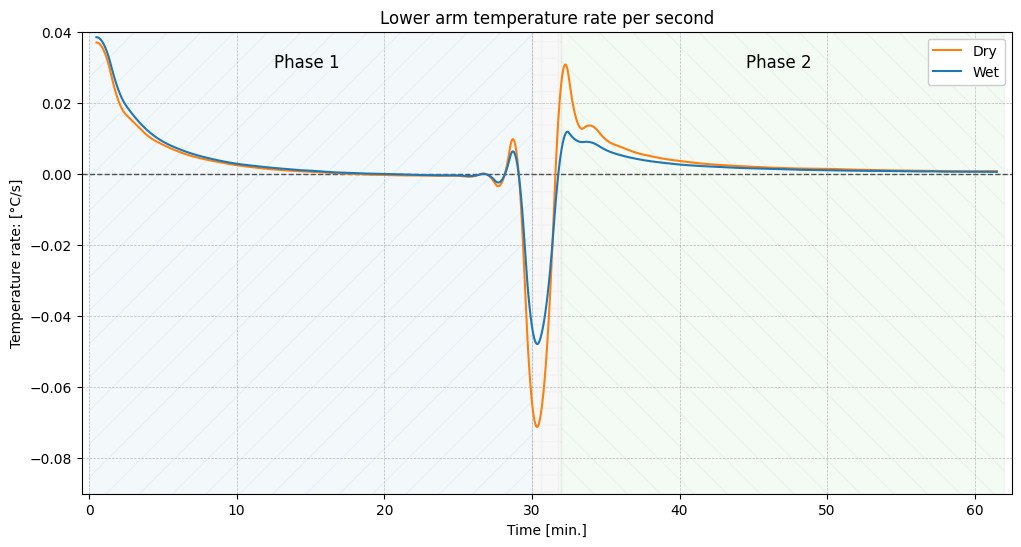

In [8]:
##########   Lower arm   ##########

Larm_TMP1D = df_1D['Channel 4']
Larm_TMP1W = df_1W['Channel 4']
Larm_TMP2D = df_2D['Channel 4']
Larm_TMP2W = df_2W['Channel 4']
Larm_TMP3D = df_3D['Channel 4']
Larm_TMP3W = df_3W['Channel 4']
Larm_TMP4D = df_4D['Channel 4']
Larm_TMP4W = df_4D['Channel 4']

Larm_min_length = min(len(Larm_TMP1D), len(Larm_TMP1W),
                      len(Larm_TMP2D), len(Larm_TMP3W),
                      len(Larm_TMP3D), len(Larm_TMP3W),
                      len(Larm_TMP4D), len(Larm_TMP4W)
                      )


Larm_TMP1D = Larm_TMP1D[:Larm_min_length]
Larm_TMP1W = Larm_TMP1W[:Larm_min_length]
Larm_TMP2D = Larm_TMP2D[:Larm_min_length]
Larm_TMP2W = Larm_TMP2W[:Larm_min_length]
Larm_TMP3D = Larm_TMP3D[:Larm_min_length]
Larm_TMP3W = Larm_TMP3W[:Larm_min_length]
Larm_TMP4D = Larm_TMP4D[:Larm_min_length]
Larm_TMP4W = Larm_TMP4W[:Larm_min_length]

#Define headers
headers = ['1D','2D','3D','4D','1W','2W','3W','4W']

#Create a dictionaries from the headers and sensor data
Larm_dict = {
    headers[0]: Larm_TMP1D,
    headers[1]: Larm_TMP2D,
    headers[2]: Larm_TMP3D,
    headers[3]: Larm_TMP4D,
    headers[4]: Larm_TMP1W,
    headers[5]: Larm_TMP2W,
    headers[6]: Larm_TMP3W,
    headers[7]: Larm_TMP4W, 
}

##########   List averages   ##########
Dry_Larm_averages = list_averages(min_length=Larm_min_length, dictionary=Larm_dict, headers=headers, start_header=0, end_header=4)
Wet_Larm_averages = list_averages(min_length=Larm_min_length, dictionary=Larm_dict, headers=headers, start_header=4, end_header=8)

##########   Local extrema   ##########
Dry_Larm_results = find_peaks_and_minima(Dry_Larm_averages, Timestamps, h=17.5, prom=1, dist=5000, h_min=-30, prom_min=1, dist_min=5000)
Wet_Larm_results = find_peaks_and_minima(Wet_Larm_averages, Timestamps, h=17.5, prom=1, dist=5000, h_min=-30, prom_min=1, dist_min=5000)

##########   Interval averages   ##########
Dry_Larm_interval_averages = interval_averages(data=Dry_Larm_averages)
Wet_Larm_interval_averages = interval_averages(data=Wet_Larm_averages)

##########   Spline interpolation   ##########
    #Dry
DLa_SI = Spline_Interpolation(list_timestamp=Timestamps_interval_averages, data_list=Dry_Larm_interval_averages, data_points=Interpolation_points)
DLa_peak_SI = Spline_Interpolation(list_timestamp=Dry_Larm_results['peak_timestamps'], data_list=Dry_Larm_results['peak_temperatures'], data_points=Interpolation_points)
DLa_min_SI = Spline_Interpolation(list_timestamp=Dry_Larm_results['minima_timestamps'], data_list=Dry_Larm_results['minima_temperatures'], data_points=Interpolation_points)
    #Wet
WLa_SI = Spline_Interpolation(list_timestamp=Timestamps_interval_averages, data_list=Wet_Larm_interval_averages, data_points=Interpolation_points)
WLa_peak_SI = Spline_Interpolation(list_timestamp=Wet_Larm_results['peak_timestamps'], data_list=Wet_Larm_results['peak_temperatures'], data_points=Interpolation_points)
WLa_min_SI = Spline_Interpolation(list_timestamp=Wet_Larm_results['minima_timestamps'], data_list=Wet_Larm_results['minima_temperatures'], data_points=Interpolation_points)

##########   Temperature difference   ##########
Larm_temp_diff = temp_diff(input_list = Dry_Larm_interval_averages, 
                            list1 = DLa_SI['cubicBC'], 
                            list2 = DLa_peak_SI['cubicBC'], 
                            list3 = DLa_min_SI['cubicBC'], 
                            list4 = Wet_Larm_interval_averages, 
                            list5 = WLa_SI['cubicBC'], 
                            list6 = WLa_peak_SI['cubicBC'], 
                            list7 = WLa_min_SI['cubicBC'] 
                            )

##########   Temperature rate [degree C/s]   ##########
Dry_Larm_temperature_rate = temperature_rate(timestamp=DLa_SI['x_interp'], data=DLa_SI['cubicBC'])
Wet_Larm_temperature_rate = temperature_rate(timestamp=WLa_SI['x_interp'], data=WLa_SI['cubicBC'])

##########   Plot   ##########
plot_template()
plt.title('Lower arm temperature')
plt.plot(Timestamps, Dry_Larm_averages, label='Dry', color='tab:orange', alpha=0.25)
plt.plot(Timestamps, Wet_Larm_averages, label='Wet', color='tab:blue', alpha=0.25)
plt.scatter(Dry_Larm_results['peak_timestamps'], Dry_Larm_results['peak_temperatures'], color='tab:Orange', edgecolors='Black', zorder=1)
plt.scatter(Dry_Larm_results['minima_timestamps'], Dry_Larm_results['minima_temperatures'], 
            color='tab:Orange', edgecolors='Black', marker='X', zorder=1)
plt.scatter(Wet_Larm_results['peak_timestamps'], Wet_Larm_results['peak_temperatures'], color='tab:blue', edgecolors='Black', zorder=2)
plt.scatter(Wet_Larm_results['minima_timestamps'], Wet_Larm_results['minima_temperatures'], 
            color='tab:blue', edgecolors='Black', marker='X', zorder=2)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='center right')

plot_template()
plt.title('Lower arm temperature: interval average')
plt.scatter(Timestamps_interval_averages, Dry_Larm_interval_averages, label='Dry', color='tab:Orange', edgecolors='Black', s=20, zorder=4)
plt.plot(DLa_SI['x_interp'], DLa_SI['cubicBC'], color='tab:Orange', zorder=2)
plt.plot(DLa_peak_SI['x_interp'], DLa_peak_SI['cubicBC'], color='tab:Orange', linestyle=':', label='Dry peak', alpha=0.5, zorder=0)
plt.plot(DLa_min_SI['x_interp'], DLa_min_SI['cubicBC'], color='tab:Orange', linestyle=':', label='Dry minima', alpha=0.5, zorder=0)
plt.scatter(Timestamps_interval_averages, Wet_Larm_interval_averages, label='Wet', color='tab:Blue', edgecolors='Black', s=20, zorder=3)
plt.plot(WLa_SI['x_interp'], WLa_SI['cubicBC'], color='tab:Blue', zorder=1)
plt.plot(WLa_peak_SI['x_interp'], WLa_peak_SI['cubicBC'], color='tab:Blue', linestyle=':', label='Wet peak', alpha=0.5, zorder=0)
plt.plot(WLa_min_SI['x_interp'], WLa_min_SI['cubicBC'], color='tab:Blue', linestyle=':', label='Wet minima', alpha=0.5, zorder=0)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='lower right')

plot_template_zoomDiff()
plt.title('Lower arm temperature difference')
plt.scatter(Timestamps_interval_averages, Larm_temp_diff[1][0], label='Dry', color='tab:Orange', edgecolors='Black', s=20, zorder=5)
plt.plot(DLa_SI['x_interp'], Larm_temp_diff[1][1], color='tab:Orange', zorder=3)
plt.plot(DLa_peak_SI['x_interp'], Larm_temp_diff[1][2], color='tab:Orange', linestyle=':', label='Dry peak', alpha=0.5, zorder=1)
plt.plot(DLa_min_SI['x_interp'], Larm_temp_diff[1][3], color='tab:Orange', linestyle=':', label='Dry minima', alpha=0.5, zorder=1)
plt.scatter(Timestamps_interval_averages, Larm_temp_diff[1][4], label='Wet', color='tab:Blue', edgecolors='Black', s=20, zorder=4)
plt.plot(WLa_SI['x_interp'], Larm_temp_diff[1][5], color='tab:Blue', zorder=2)
plt.plot(WLa_peak_SI['x_interp'], Larm_temp_diff[1][6], color='tab:Blue', linestyle=':', label='Wet peak', alpha=0.5, zorder=1)
plt.plot(WLa_min_SI['x_interp'], Larm_temp_diff[1][7], color='tab:Blue', linestyle=':', label='Wet minima', alpha=0.5, zorder=1)
plt.axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='upper left')

plot_template_rate_min()
plt.title('Lower arm temperature rate per minute')
plt.plot(Dry_Larm_temperature_rate[0], Dry_Larm_temperature_rate[1], color='tab:Orange', label='Dry')
plt.plot(Wet_Larm_temperature_rate[0], Wet_Larm_temperature_rate[1], color='tab:Blue', label='Wet')
plt.axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='best')

plot_template_rate_seconds()
plt.title('Lower arm temperature rate per second')
plt.plot(Dry_Larm_temperature_rate[0], Dry_Larm_temperature_rate[2], color='tab:Orange', label='Dry')
plt.plot(Wet_Larm_temperature_rate[0], Wet_Larm_temperature_rate[2], color='tab:Blue', label='Wet')
plt.axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='best')

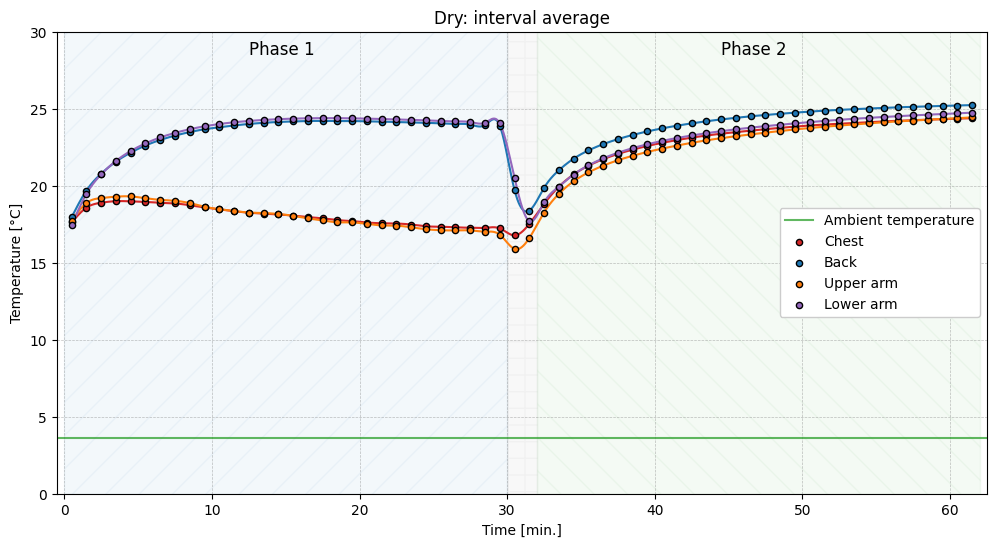

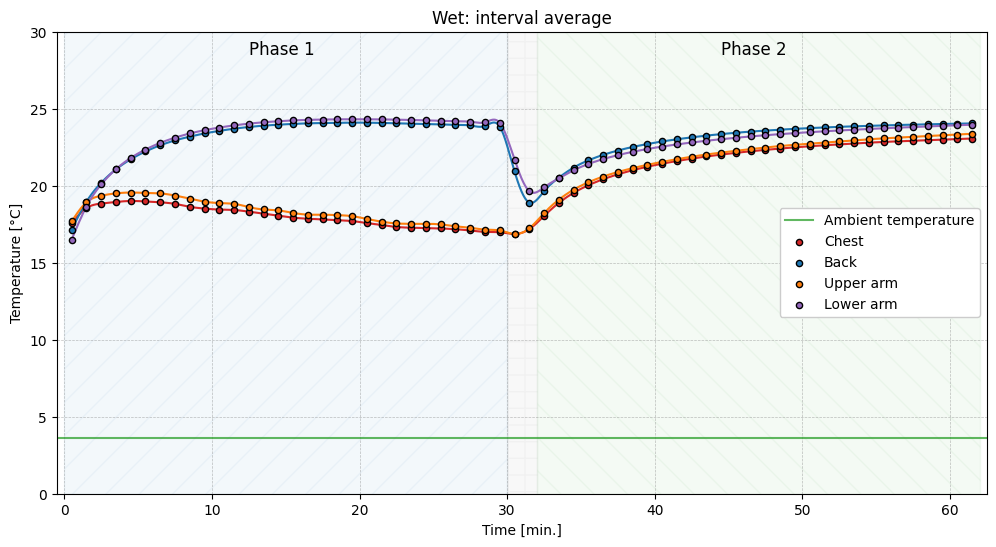

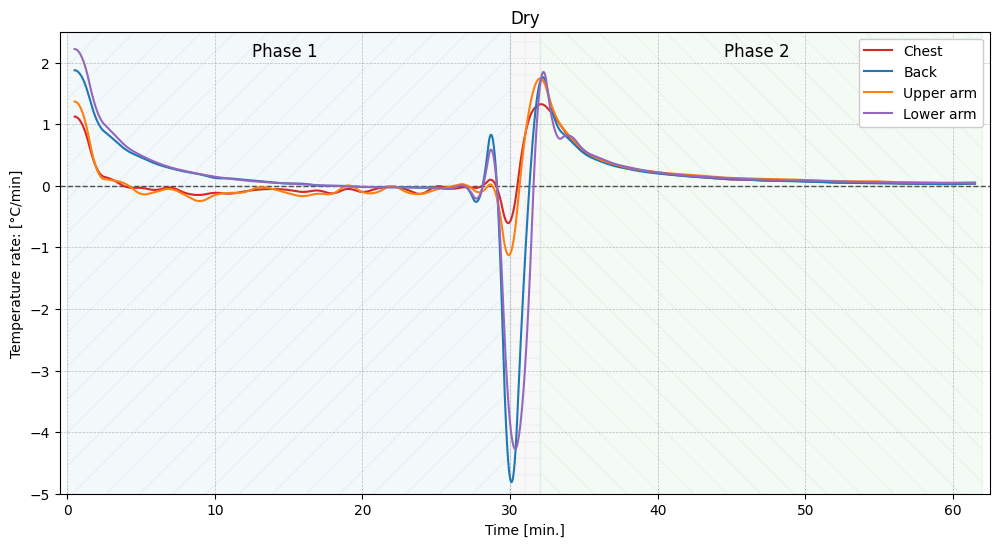

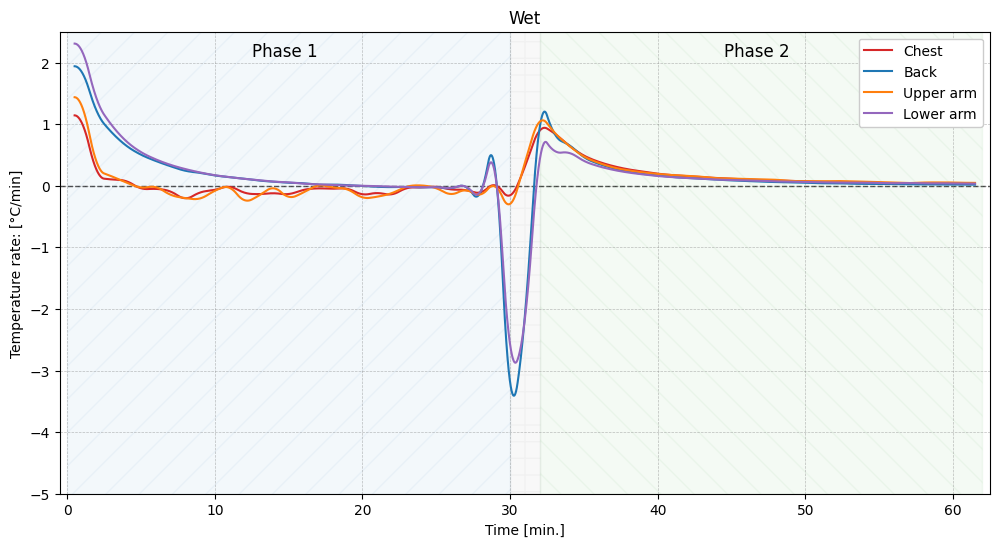

In [9]:
# Dry vs Wet

plot_template()
plt.title('Dry: interval average')
plt.scatter(Timestamps_interval_averages, Dry_Chest_interval_averages, label='Chest', color='tab:Red', edgecolors='Black', s=20, zorder=4)
plt.plot(DC_SI['x_interp'], DC_SI['cubicBC'], color='tab:Red', zorder=2)
plt.scatter(Timestamps_interval_averages, Dry_Back_interval_averages, label='Back', color='tab:Blue', edgecolors='Black', s=20, zorder=4)
plt.plot(DB_SI['x_interp'], DB_SI['cubicBC'], color='tab:Blue', zorder=2)
plt.scatter(Timestamps_interval_averages, Dry_Uarm_interval_averages, label='Upper arm', color='tab:Orange', edgecolors='Black', s=20, zorder=4)
plt.plot(DUa_SI['x_interp'], DUa_SI['cubicBC'], color='tab:Orange', zorder=2)
plt.scatter(Timestamps_interval_averages, Dry_Larm_interval_averages, label='Lower arm', color='tab:Purple', edgecolors='Black', s=20, zorder=4)
plt.plot(DLa_SI['x_interp'], DLa_SI['cubicBC'], color='tab:Purple', zorder=2)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='best')

plot_template()
plt.title('Wet: interval average')
plt.scatter(Timestamps_interval_averages, Wet_Chest_interval_averages, label='Chest', color='tab:Red', edgecolors='Black', s=20, zorder=4)
plt.plot(WC_SI['x_interp'], WC_SI['cubicBC'], color='tab:Red', zorder=2)
plt.scatter(Timestamps_interval_averages, Wet_Back_interval_averages, label='Back', color='tab:Blue', edgecolors='Black', s=20, zorder=4)
plt.plot(WB_SI['x_interp'], WB_SI['cubicBC'], color='tab:Blue', zorder=2)
plt.scatter(Timestamps_interval_averages, Wet_Uarm_interval_averages, label='Upper arm', color='tab:Orange', edgecolors='Black', s=20, zorder=4)
plt.plot(WUa_SI['x_interp'], WUa_SI['cubicBC'], color='tab:Orange', zorder=2)
plt.scatter(Timestamps_interval_averages, Wet_Larm_interval_averages, label='Lower arm', color='tab:Purple', edgecolors='Black', s=20, zorder=4)
plt.plot(WLa_SI['x_interp'], WLa_SI['cubicBC'], color='tab:Purple', zorder=2)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='best')


plot_template_rate_min()
plt.title('Dry')
plt.plot(Dry_chest_temperature_rate[0], Dry_chest_temperature_rate[1], color='tab:Red', label='Chest')
plt.plot(Dry_back_temperature_rate[0], Dry_back_temperature_rate[1], color='tab:Blue', label='Back')
plt.plot(Dry_Uarm_temperature_rate[0], Dry_Uarm_temperature_rate[1], color='tab:Orange', label='Upper arm')
plt.plot(Dry_Larm_temperature_rate[0], Dry_Larm_temperature_rate[1], color='tab:Purple', label='Lower arm')
plt.axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='best')

plot_template_rate_min()
plt.title('Wet')
plt.plot(Wet_chest_temperature_rate[0], Wet_chest_temperature_rate[1], color='tab:Red', label='Chest')
plt.plot(Wet_back_temperature_rate[0], Wet_back_temperature_rate[1], color='tab:Blue', label='Back')
plt.plot(Wet_Uarm_temperature_rate[0], Wet_Uarm_temperature_rate[1], color='tab:Orange', label='Upper arm')
plt.plot(Wet_Larm_temperature_rate[0], Wet_Larm_temperature_rate[1], color='tab:Purple', label='Lower arm')
plt.axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='best')

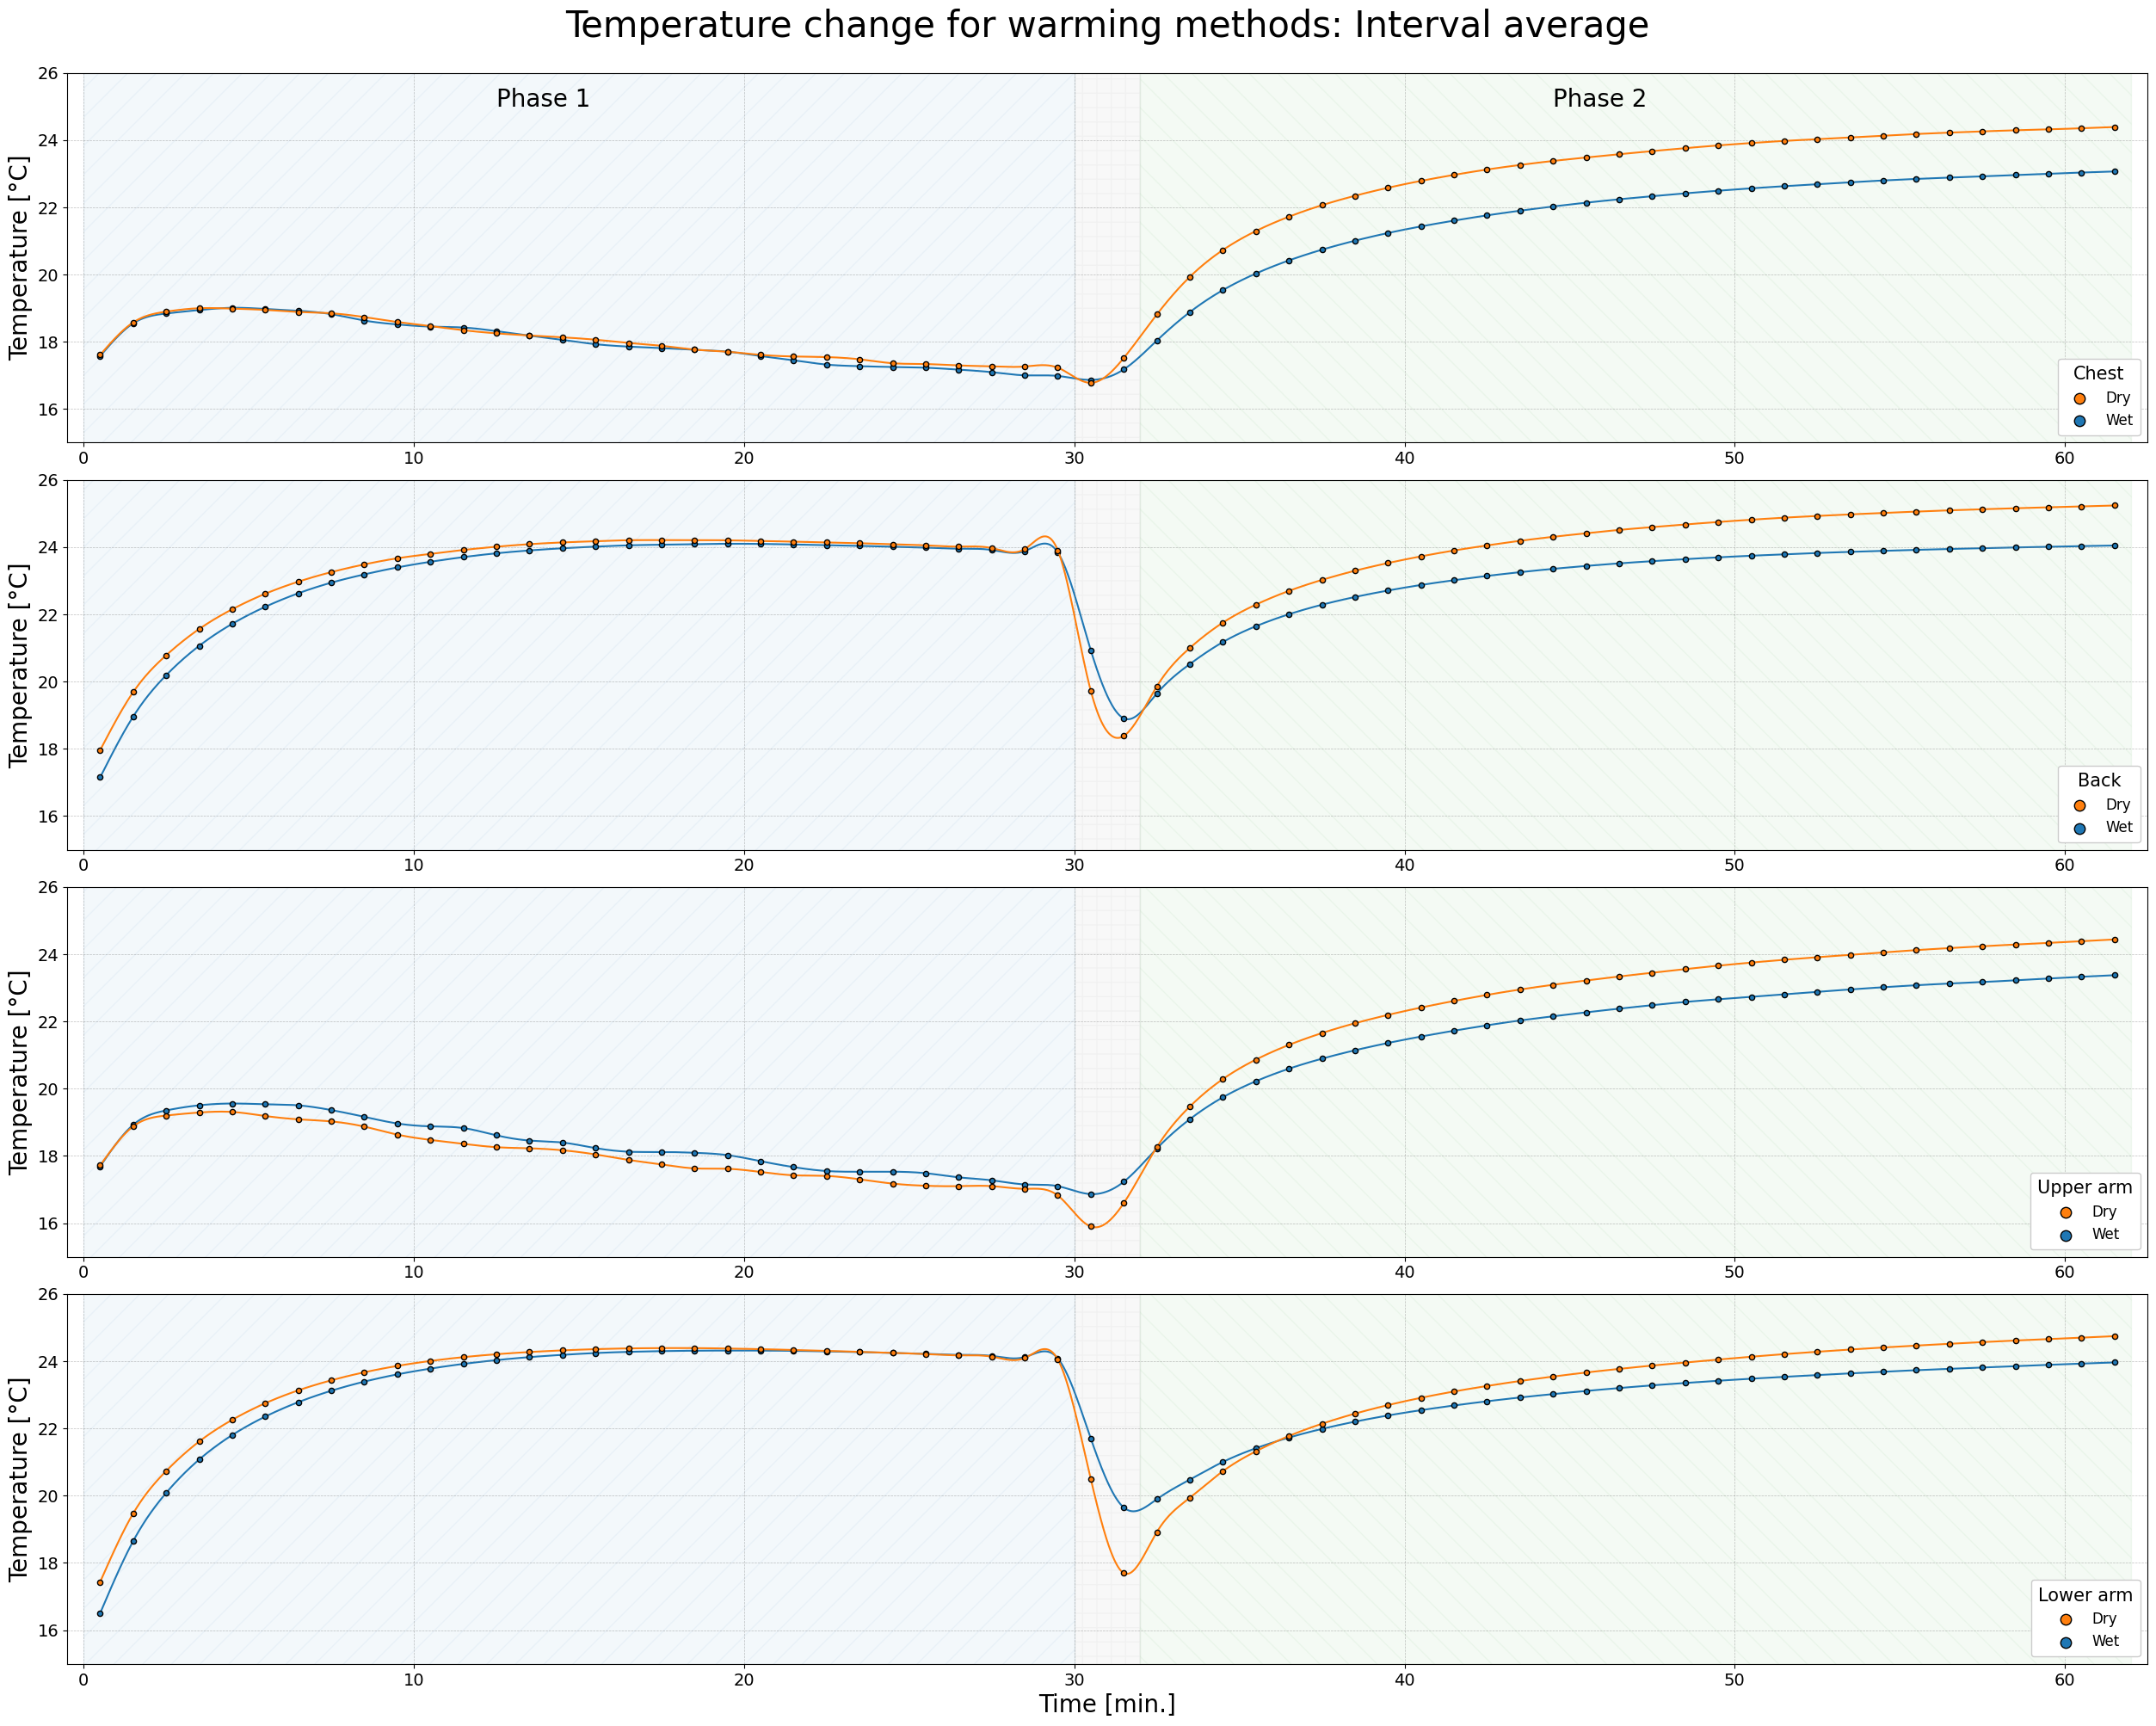

In [10]:
def ax_plot_template(ax):
    ax.set_ylim(15, 26)
    ax.set_xlim(-0.5, 62.5)
    #ax.set_xlabel('Time [min.]', fontsize='10')
    ax.set_ylabel('Temperature [\u00b0C]', fontsize='20')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='gray', axis='both', which='both', zorder=0)
    ax.axvspan(0, 30, color='tab:Blue', alpha=0.05, hatch='/')
    ax.axvspan(30, 32, color='tab:Gray', alpha=0.05, hatch='+')
    ax.axvspan(32, 62, color='tab:Green', alpha=0.05, hatch='\\')
    #ax.text(12.5, 25.25, 'Phase 1', fontsize='large', bbox=dict(facecolor='none', edgecolor='none'))
    #ax.text(44.5, 25.25, 'Phase 2', fontsize='large', bbox=dict(facecolor='none', edgecolor='none'))
    ax.tick_params(axis='both', which='both', labelsize=14)  # Set the font size for both axes


# Create a 1x2 grid of subplots
fig, ax = plt.subplots(4, 1, figsize=(25, 20))

# First subplot for Dry data
ax_plot_template(ax=ax[0])
ax[0].set_title('Temperature change for warming methods: Interval average', fontsize='30', fontweight='light', pad=30)
ax[0].text(12.5, 25, 'Phase 1', fontsize='20', bbox=dict(facecolor='none', edgecolor='none'))
ax[0].text(44.5, 25, 'Phase 2', fontsize='20', bbox=dict(facecolor='none', edgecolor='none'))
ax[0].scatter(Timestamps_interval_averages, Dry_Chest_interval_averages, label='Dry', color='tab:Orange', edgecolors='Black', s=20, zorder=4)
ax[0].plot(DC_SI['x_interp'], DC_SI['cubicBC'], color='tab:Orange', zorder=3)
ax[0].scatter(Timestamps_interval_averages, Wet_Chest_interval_averages, label='Wet', color='tab:Blue', edgecolors='Black', s=20, zorder=2)
ax[0].plot(WC_SI['x_interp'], WC_SI['cubicBC'], color='tab:Blue', zorder=1)
ax[0].legend(title = "Chest", fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='lower right',
             fontsize='large', title_fontsize='15', borderpad=0.5, labelspacing=0.5, markerscale=2)

# Second subplot for Wet data
ax_plot_template(ax=ax[1])
#ax[1].set_title('Back: interval average')
ax[1].scatter(Timestamps_interval_averages, Dry_Back_interval_averages, label='Dry', color='tab:Orange', edgecolors='Black', s=20, zorder=4)
ax[1].plot(DB_SI['x_interp'], DB_SI['cubicBC'], color='tab:Orange', zorder=3)
ax[1].scatter(Timestamps_interval_averages, Wet_Back_interval_averages, label='Wet', color='tab:Blue', edgecolors='Black', s=20, zorder=2)
ax[1].plot(WB_SI['x_interp'], WB_SI['cubicBC'], color='tab:Blue', zorder=1)
ax[1].legend(title = "Back", fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='lower right',
             fontsize='large', title_fontsize='15', borderpad=0.5, labelspacing=0.5, markerscale=2)

ax_plot_template(ax=ax[2])
#ax[2].set_title('Upper arm: interval average')
ax[2].scatter(Timestamps_interval_averages, Dry_Uarm_interval_averages, label='Dry', color='tab:Orange', edgecolors='Black', s=20, zorder=4)
ax[2].plot(DUa_SI['x_interp'], DUa_SI['cubicBC'], color='tab:Orange', zorder=3)
ax[2].scatter(Timestamps_interval_averages, Wet_Uarm_interval_averages, label='Wet', color='tab:Blue', edgecolors='Black', s=20, zorder=2)
ax[2].plot(WUa_SI['x_interp'], WUa_SI['cubicBC'], color='tab:Blue', zorder=1)
ax[2].legend(title = "Upper arm", fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='lower right',
             fontsize='large', title_fontsize='15', borderpad=0.5, labelspacing=0.5, markerscale=2)

ax_plot_template(ax=ax[3])
#ax[3].set_title('Lower arm: interval average')¨
ax[3].set_xlabel('Time [min.]', fontsize='20')
ax[3].scatter(Timestamps_interval_averages, Dry_Larm_interval_averages, label='Dry', color='tab:Orange', edgecolors='Black', s=20, zorder=4)
ax[3].plot(DLa_SI['x_interp'], DLa_SI['cubicBC'], color='tab:Orange', zorder=3)
ax[3].scatter(Timestamps_interval_averages, Wet_Larm_interval_averages, label='Wet', color='tab:Blue', edgecolors='Black', s=20, zorder=2)
ax[3].plot(WLa_SI['x_interp'], WLa_SI['cubicBC'], color='tab:Blue', zorder=1)
ax[3].legend(title = "Lower arm", fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='lower right',
             fontsize='large', title_fontsize='15', borderpad=0.5, labelspacing=0.5, markerscale=2)

# Improve layout and display the plot
plt.tight_layout(pad=0.5)  # Automatically adjust with padding
plt.show()

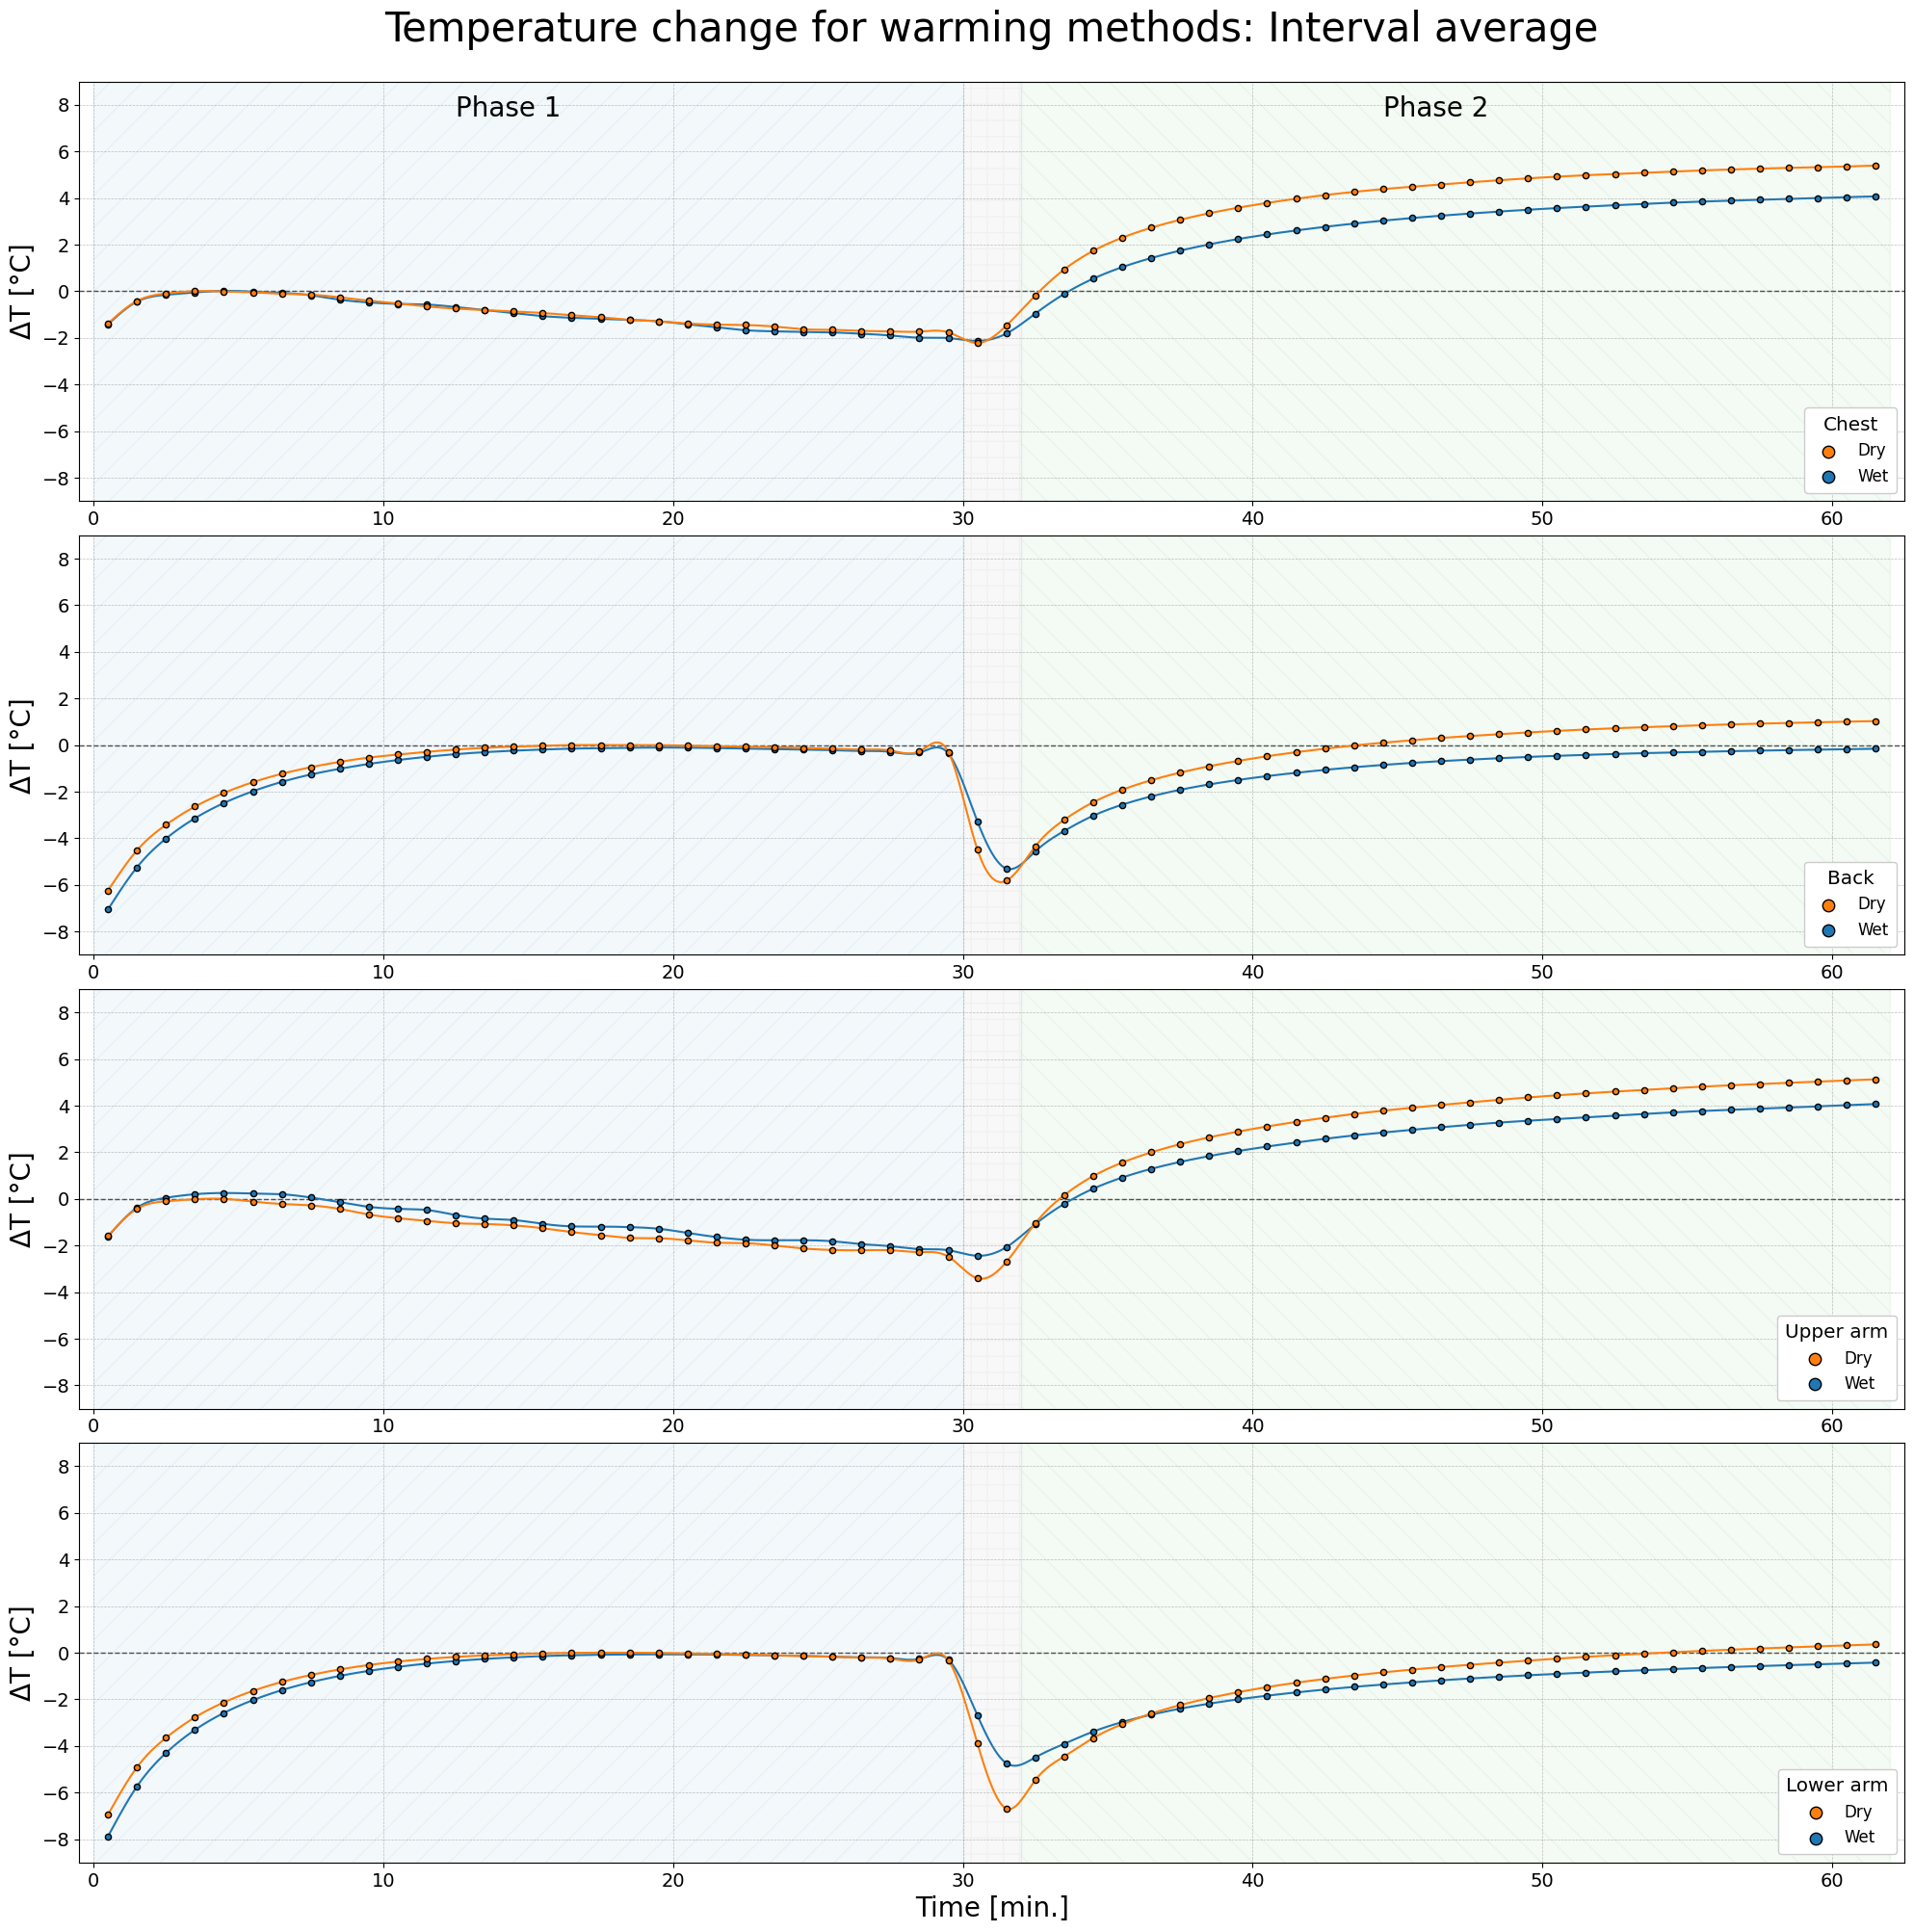

In [11]:
def ax_temp_diff_plot_template(ax):
    ax.set_ylim(-9, 9)
    ax.set_xlim(-0.5, 62.5)
    #ax.set_xlabel('Time [min.]', fontsize='20')
    ax.set_ylabel('\u0394T [\u00b0C]', fontsize='20')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='gray', axis='both', which='both', zorder=0)
    ax.axvspan(0, 30, color='tab:Blue', alpha=0.05, hatch='/')
    ax.axvspan(30, 32, color='tab:Gray', alpha=0.05, hatch='+')
    ax.axvspan(32, 62, color='tab:Green', alpha=0.05, hatch='\\')
    #ax.text(12.5, 7.5, 'Phase 1', fontsize='20', bbox=dict(facecolor='none', edgecolor='none'))
    #ax.text(44.5, 7.5, 'Phase 2', fontsize='20', bbox=dict(facecolor='none', edgecolor='none'))
    ax.tick_params(axis='both', which='both', labelsize=14)  # Set the font size for both axes
    ax.axhline(y=0, color='Black', linestyle='--', alpha=0.75, linewidth=1, zorder=0)


# Create a 1x2 grid of subplots
fig, ax = plt.subplots(4, 1, figsize=(20, 20))

# First subplot for Dry data
ax_temp_diff_plot_template(ax=ax[0])
ax[0].text(12.5, 7.5, 'Phase 1', fontsize='20', bbox=dict(facecolor='none', edgecolor='none'))
ax[0].text(44.5, 7.5, 'Phase 2', fontsize='20', bbox=dict(facecolor='none', edgecolor='none'))
ax[0].set_title('Temperature change for warming methods: Interval average', fontsize='30', fontweight='light', pad=30)
ax[0].scatter(Timestamps_interval_averages, Chest_temp_diff[1][0], label='Dry', color='tab:Orange', edgecolors='Black', s=20, zorder=4)
ax[0].plot(DC_SI['x_interp'], Chest_temp_diff[1][1], color='tab:Orange', zorder=3)
ax[0].scatter(Timestamps_interval_averages, Chest_temp_diff[1][4], label='Wet', color='tab:Blue', edgecolors='Black', s=20, zorder=2)
ax[0].plot(WC_SI['x_interp'], Chest_temp_diff[1][5], color='tab:Blue', zorder=1)
ax[0].legend(title = "Chest", fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='lower right',
             fontsize='large', title_fontsize='x-large', borderpad=0.5, labelspacing=0.5, markerscale=2)

# Second subplot for Wet data
ax_temp_diff_plot_template(ax=ax[1])
#ax[1].set_title('Back: interval average')
ax[1].scatter(Timestamps_interval_averages, Back_temp_diff[1][0], label='Dry', color='tab:Orange', edgecolors='Black', s=20, zorder=4)
ax[1].plot(DB_SI['x_interp'], Back_temp_diff[1][1], color='tab:Orange', zorder=3)
ax[1].scatter(Timestamps_interval_averages, Back_temp_diff[1][4], label='Wet', color='tab:Blue', edgecolors='Black', s=20, zorder=2)
ax[1].plot(WB_SI['x_interp'], Back_temp_diff[1][5], color='tab:Blue', zorder=1)
ax[1].legend(title = "Back", fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='lower right',
             fontsize='large', title_fontsize='x-large', borderpad=0.5, labelspacing=0.5, markerscale=2)

ax_temp_diff_plot_template(ax=ax[2])
#ax[2].set_title('Upper arm: interval average')
ax[2].scatter(Timestamps_interval_averages, Uarm_temp_diff[1][0], label='Dry', color='tab:Orange', edgecolors='Black', s=20, zorder=4)
ax[2].plot(DUa_SI['x_interp'], Uarm_temp_diff[1][1], color='tab:Orange', zorder=3)
ax[2].scatter(Timestamps_interval_averages, Uarm_temp_diff[1][4], label='Wet', color='tab:Blue', edgecolors='Black', s=20, zorder=2)
ax[2].plot(WUa_SI['x_interp'], Uarm_temp_diff[1][5], color='tab:Blue', zorder=1)
ax[2].legend(title = "Upper arm", fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='lower right',
             fontsize='large', title_fontsize='x-large', borderpad=0.5, labelspacing=0.5, markerscale=2)

ax_temp_diff_plot_template(ax=ax[3])
#ax[3].set_title('Lower arm: interval average')
ax[3].set_xlabel('Time [min.]', fontsize='20')
ax[3].scatter(Timestamps_interval_averages, Larm_temp_diff[1][0], label='Dry', color='tab:Orange', edgecolors='Black', s=20, zorder=4)
ax[3].plot(DLa_SI['x_interp'], Larm_temp_diff[1][1], color='tab:Orange', zorder=3)
ax[3].scatter(Timestamps_interval_averages, Larm_temp_diff[1][4], label='Wet', color='tab:Blue', edgecolors='Black', s=20, zorder=2)
ax[3].plot(WLa_SI['x_interp'], Larm_temp_diff[1][5], color='tab:Blue', zorder=1)
ax[3].legend(title = "Lower arm", fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='lower right',
             fontsize='large', title_fontsize='x-large', borderpad=0.5, labelspacing=0.5, markerscale=2)

# Improve layout and display the plot
plt.tight_layout(pad=0.5)  # Automatically adjust with padding
plt.show()

In [12]:
print('Chest = ',DC_SI['cubicBC'][-1] ,':', WC_SI['cubicBC'][-1], '      Diff = ', DC_SI['cubicBC'][-1] - WC_SI['cubicBC'][-1])
print('Back = ',DB_SI['cubicBC'][-1] ,':', WB_SI['cubicBC'][-1], '      Diff = ', DB_SI['cubicBC'][-1] - WB_SI['cubicBC'][-1])
print('Upper arm = ',DUa_SI['cubicBC'][-1] ,':', WUa_SI['cubicBC'][-1], '      Diff = ', DUa_SI['cubicBC'][-1] - WUa_SI['cubicBC'][-1])
print('Lower arm = ',DLa_SI['cubicBC'][-1] ,':', WLa_SI['cubicBC'][-1], '      Diff = ', DLa_SI['cubicBC'][-1] - WLa_SI['cubicBC'][-1])

def first_index_above_zero(input_list, start_index):
    for index in range(start_index + 1, len(input_list)):
        if input_list[index] > 0:
            return index
    return -1  # Return -1 if no value above 0 is found after the given index

def minutes_to_minutes_seconds(total_minutes):
    minutes = int(total_minutes)
    seconds = int((total_minutes - minutes) * 60)
    return f"{minutes} minutes and {seconds} seconds"

dry_index = first_index_above_zero(Chest_temp_diff[1][1], int(len(Chest_temp_diff[1][1])/2))
wet_index = first_index_above_zero(Chest_temp_diff[1][5], int(len(Chest_temp_diff[1][5])/2))
Phase2_startTime = 32
DT = DC_SI['x_interp'][dry_index] - Phase2_startTime
WT = WC_SI['x_interp'][wet_index] - Phase2_startTime
dry_time = minutes_to_minutes_seconds(DT)
wet_time = minutes_to_minutes_seconds(WT)
print(dry_time)
print(wet_time)

Chest =  24.386295663052536 : 23.064964136780652       Diff =  1.3213315262718837
Back =  25.23623603002502 : 24.046058798999166       Diff =  1.190177231025853
Upper arm =  24.436535029190992 : 23.37278565471226       Diff =  1.063749374478732
Lower arm =  24.743731442869056 : 23.961787739783155       Diff =  0.7819437030859007
0 minutes and 38 seconds
1 minutes and 39 seconds


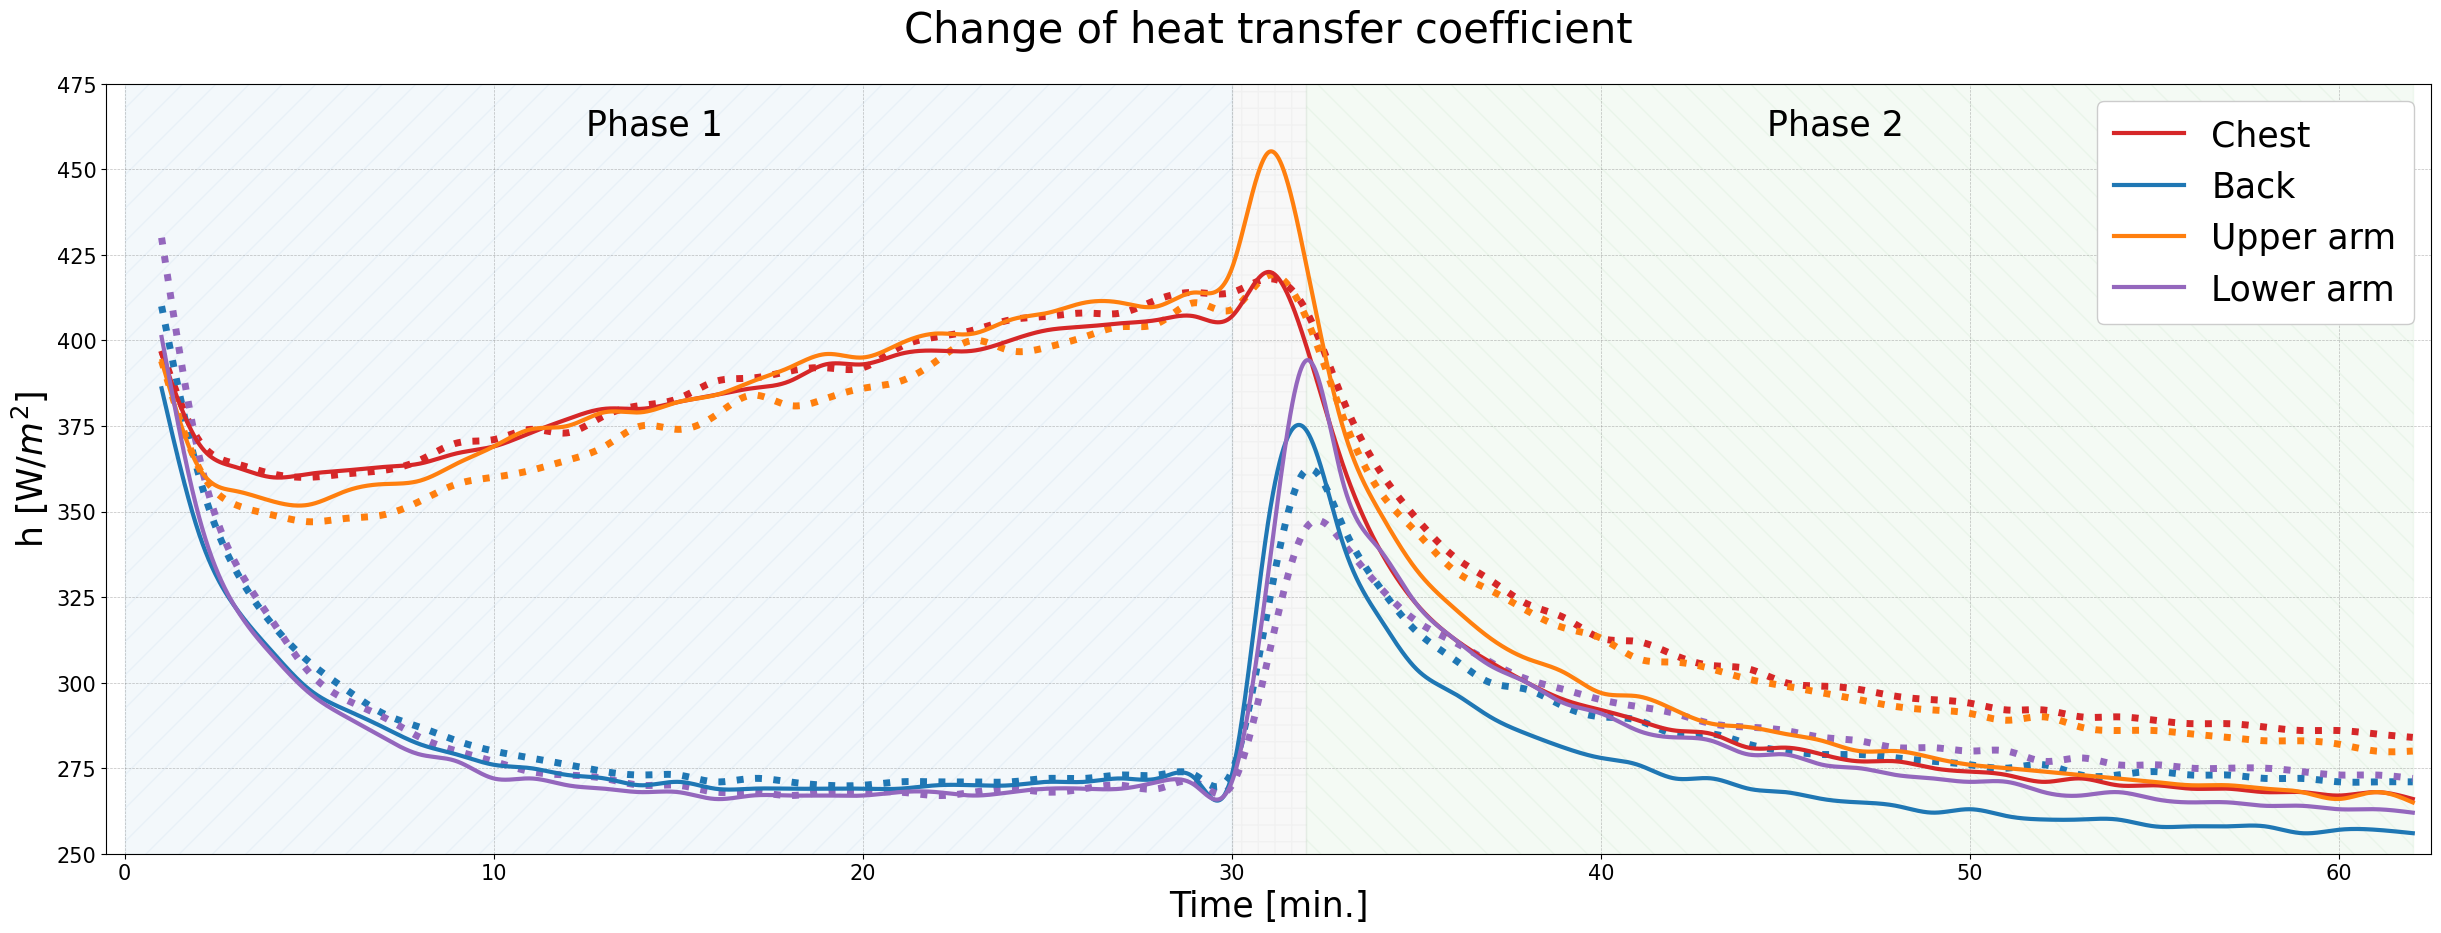

In [13]:
def calculate_h(data, C, data_top_indices, data_bottom_indices):   

    # Find the indices of the top points
    top_indices = data_top_indices # = number of cycles
    bottom_indices = data_bottom_indices
    bottom_indices=np.concatenate((np.array([0]),bottom_indices,np.array([len(data)-1])),axis=0)
 
    mc=30*30*0.75*2.7e-3*0.9 # A*t*p*C
    h_values=np.zeros_like(top_indices)
 
    for i in range(len(top_indices)):
        bottom_index=bottom_indices[i]
        next_bottom_index=bottom_indices[i+1]
       
        h_values[i]=(C*0.7-mc*(data[next_bottom_index]-data[bottom_index])/(next_bottom_index-bottom_index))/(900*(np.mean(data[bottom_index:next_bottom_index])-3.6))*10e5
       
    return h_values

Dry_Chest_h = calculate_h(data=np.array(Dry_Chest_averages), C=25/3.5, data_top_indices=Dry_Chest_results['peak_indices'], data_bottom_indices=Dry_Chest_results['minima_indices'])
Wet_Chest_h = calculate_h(data=np.array(Wet_Chest_averages), C=25/3.5, data_top_indices=Wet_Chest_results['peak_indices'], data_bottom_indices=Wet_Chest_results['minima_indices'])
Dry_Back_h = calculate_h(data=np.array(Dry_Back_averages), C=25/3.5, data_top_indices=Dry_Back_results['peak_indices'], data_bottom_indices=Dry_Back_results['minima_indices'])
Wet_Back_h = calculate_h(data=np.array(Wet_Back_averages), C=25/3.5, data_top_indices=Wet_Back_results['peak_indices'], data_bottom_indices=Wet_Back_results['minima_indices'])
Dry_Uarm_h = calculate_h(data=np.array(Dry_Uarm_averages), C=25/3.5, data_top_indices=Dry_Uarm_results['peak_indices'], data_bottom_indices=Dry_Uarm_results['minima_indices'])
Wet_Uarm_h = calculate_h(data=np.array(Wet_Uarm_averages), C=25/3.5, data_top_indices=Wet_Uarm_results['peak_indices'], data_bottom_indices=Wet_Uarm_results['minima_indices'])
Dry_Larm_h = calculate_h(data=np.array(Dry_Larm_averages), C=25/3.5, data_top_indices=Dry_Larm_results['peak_indices'], data_bottom_indices=Dry_Larm_results['minima_indices'])
Wet_Larm_h = calculate_h(data=np.array(Wet_Larm_averages), C=25/3.5, data_top_indices=Wet_Larm_results['peak_indices'], data_bottom_indices=Wet_Larm_results['minima_indices'])

Timestamp_h = np.linspace(1,62,62)

'''
print((Timestamp_h))
print(len(Dry_Chest_h))
print(len(Dry_Back_h))
print(len(Dry_Uarm_h))
print(len(Dry_Larm_h))
print(len(Wet_Chest_h))
print(len(Wet_Back_h))
print(len(Wet_Uarm_h))
print(len(Wet_Larm_h))
'''

##########   Spline interpolation   ##########
    #Dry
DC_SI_h = Spline_Interpolation(list_timestamp=Timestamp_h, data_list=Dry_Chest_h, data_points=Interpolation_points)
DB_SI_h = Spline_Interpolation(list_timestamp=Timestamp_h, data_list=Dry_Back_h, data_points=Interpolation_points)
DUa_SI_h = Spline_Interpolation(list_timestamp=Timestamp_h, data_list=Dry_Uarm_h, data_points=Interpolation_points)
DLa_SI_h = Spline_Interpolation(list_timestamp=Timestamp_h, data_list=Dry_Larm_h, data_points=Interpolation_points)
    #Wet
WC_SI_h = Spline_Interpolation(list_timestamp=Timestamp_h, data_list=Wet_Chest_h, data_points=Interpolation_points)
WB_SI_h = Spline_Interpolation(list_timestamp=Timestamp_h, data_list=Wet_Back_h, data_points=Interpolation_points)
WUa_SI_h = Spline_Interpolation(list_timestamp=Timestamp_h, data_list=Wet_Uarm_h, data_points=Interpolation_points)
WLa_SI_h = Spline_Interpolation(list_timestamp=Timestamp_h, data_list=Wet_Larm_h, data_points=Interpolation_points)

plt.figure(figsize=(30,10))
plt.ylim(250, 475)
plt.xlim(-0.5, 62.5)
plt.title('Change of heat transfer coefficient', fontsize='30', fontweight='light', pad=30)
plt.xlabel('Time [min.]', fontsize='25')
plt.ylabel('h [W/$m^2$]', fontsize='25')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='gray', axis='both', which='both', zorder=0)
plt.axvspan(0, 30, color='tab:Blue', alpha=0.05, hatch='/')
plt.axvspan(30, 32, color='tab:Gray', alpha=0.05, hatch='+')
plt.axvspan(32, 62, color='tab:Green', alpha=0.05, hatch='\\')
#Adding text inside a rectangular box by using the keyword 'bbox'
plt.text(12.5, 460, 'Phase 1', fontsize='25', bbox=dict(facecolor='none', edgecolor='none'))
plt.text(44.5, 460, 'Phase 2', fontsize='25', bbox=dict(facecolor='none', edgecolor='none'))
plt.tick_params(axis='both', which='both', labelsize=15)  # Set the font size for both axes


'''
plt.plot(Timestamp_h, Dry_Chest_h, color='tab:Red', label='Chest', zorder=3)
plt.plot(Timestamp_h, Dry_Back_h, color='tab:Blue', label='Back', zorder=3)
plt.plot(Timestamp_h, Dry_Uarm_h, color='tab:Orange', label='Upper arm', zorder=3)
plt.plot(Timestamp_h, Dry_Larm_h, color='tab:Purple', label='Lower arm', zorder=3)

plt.plot(Timestamp_h, Wet_Chest_h, color='tab:Red', linestyle='--', zorder=2)
plt.plot(Timestamp_h, Wet_Back_h, color='tab:Blue', linestyle='--', zorder=2)
plt.plot(Timestamp_h, Wet_Uarm_h, color='tab:Orange', linestyle='--', zorder=2)
plt.plot(Timestamp_h, Wet_Larm_h, color='tab:Purple', linestyle='--', zorder=2)
'''

plt.plot(DC_SI_h['x_interp'], DC_SI_h['cubicBC'], color='tab:Red', label='Chest', linewidth=3, zorder=3)
plt.plot(DB_SI_h['x_interp'], DB_SI_h['cubicBC'], color='tab:Blue', label='Back', linewidth=3, zorder=3)
plt.plot(DUa_SI_h['x_interp'], DUa_SI_h['cubicBC'], color='tab:Orange', label='Upper arm', linewidth=3, zorder=3)
plt.plot(DLa_SI_h['x_interp'], DLa_SI_h['cubicBC'], color='tab:Purple', label='Lower arm', linewidth=3, zorder=3)

plt.plot(WC_SI_h['x_interp'], WC_SI_h['cubicBC'], color='tab:Red', linestyle=':', linewidth=5, zorder=2)
plt.plot(WB_SI_h['x_interp'], WB_SI_h['cubicBC'], color='tab:Blue', linestyle=':', linewidth=5, zorder=2)
plt.plot(WUa_SI_h['x_interp'], WUa_SI_h['cubicBC'], color='tab:Orange', linestyle=':', linewidth=5, zorder=2)
plt.plot(WLa_SI_h['x_interp'], WLa_SI_h['cubicBC'], color='tab:Purple', linestyle=':', linewidth=5, zorder=2)


plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='upper right',
             fontsize='25', title_fontsize='x-large', borderpad=0.5, labelspacing=0.5, markerscale=2)


3400 3400
1200 1200
17.4 23.3
11.5 15.8


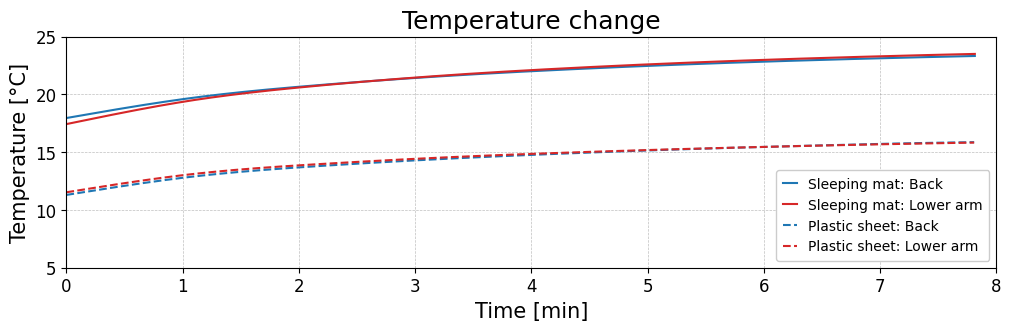

5.4 6.1
4.6 4.3


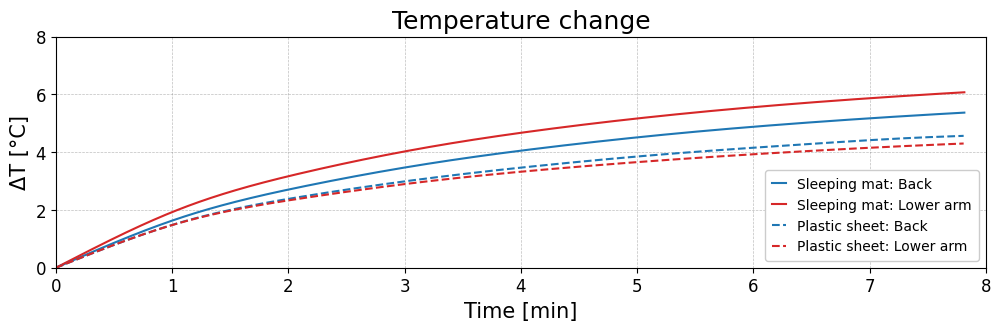

In [14]:
#Iteration 12 Floor insulation

Floor = pd.read_csv('Test data/Floor-without-sleeping_mat.csv')


Floor_Back = Floor['Channel 2']
Floor_Larm = Floor['Channel 4']

Timestamps = [i * SamplingRate_minutes for i in range (0, len(Floor_Back))]

##########   Interval averages   ##########
Timestamps_interval_averages = interval_averages(data=Timestamps)
Floor_Back_interval_averages = interval_averages(data=Floor_Back)
Floor_Larm_interval_averages = interval_averages(data=Floor_Larm)

##########   Spline interpolation   ##########
FB_SI = Spline_Interpolation(list_timestamp=Timestamps_interval_averages, data_list=Floor_Back_interval_averages, data_points=Interpolation_points)
FLa_SI = Spline_Interpolation(list_timestamp=Timestamps_interval_averages, data_list=Floor_Larm_interval_averages, data_points=Interpolation_points)


import math
def DFFV(lst):
    # Find the first non-NaN value
    first_index = None
    for item in lst:
        if not math.isnan(item):
            first_index = item
            break
    
    # Check if there was no valid non-NaN value found
    if first_index is None:
        raise ValueError("List contains only NaN values")

    DFFV_list = []
    for item in lst:
        if math.isnan(item):
            DFFV_list.append(float('nan'))  # Append NaN for NaN values
        else:
            diff = item - first_index
            DFFV_list.append(diff)
    
    return DFFV_list


end_value2 = 1200
TimestampBackSM = DB_SI['x_interp'][:end_value2]
SM_Back2 = DB_SI['cubicBC'][:end_value2]
SM_Larm2 = DLa_SI['cubicBC'][:end_value2]


end_value3 = 3400

TimestampBackF = FB_SI['x_interp'][:end_value3] 
F_Back2 = FB_SI['cubicBC'][:end_value3]
F_Larm2 = FLa_SI['cubicBC'][:end_value3]

TimestampSM2 = np.linspace(0,TimestampBackSM[-1],len(TimestampBackSM))
TimestampF2 = np.linspace(0,TimestampBackF[-1],len(TimestampBackF))

#DFF
DFF_FBack = DFFV(F_Back2)
DFF_FLarm = DFFV(F_Larm2)

print(len(F_Back2), len(DFF_FBack))

TimestampsDFF_Floor = FB_SI['x_interp'][:len(DFF_FBack)]

DFF_SMBack = DFFV(SM_Back2)
DFF_SMLarm = DFFV(SM_Larm2)

print(len(SM_Back2), len(DFF_SMBack))

TimestampsDFF_SM = DB_SI['x_interp'][:len(DFF_SMBack)]

print(round(SM_Larm2[0],1), round(SM_Back2[-1],1))
print(round(F_Larm2[0],1), round(F_Larm2[-1],1))


plt.figure(figsize=(12,3))
plt.title('Temperature change', fontsize='18')
plt.ylim(5, 25)
plt.xlim(0, 8)
plt.xlabel('Time [min]', fontsize='15')
plt.ylabel('Temperature [\u00b0C]', fontsize='15')
plt.tick_params(axis='both', which='both', labelsize=12)  # Set the font size for both axes
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='gray', axis='both', which='both', zorder=0)
plt.plot(TimestampSM2, SM_Back2, label='Sleeping mat: Back', color='tab:Blue', linewidth=1.5, zorder=2)
plt.plot(TimestampSM2, SM_Larm2, label='Sleeping mat: Lower arm', color='tab:Red', linewidth=1.5, zorder=2)
plt.plot(TimestampF2, F_Back2, label='Plastic sheet: Back', color='tab:Blue', linestyle='--', linewidth=1.5, zorder=2)
plt.plot(TimestampF2, F_Larm2, label='Plastic sheet: Lower arm', color='tab:Red', linestyle='--', linewidth=1.5, zorder=2)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='lower right',
           fontsize='10', borderpad=0.5, labelspacing=0.5, handlelength=1)
plt.show()

print(round(DFF_SMBack[-1],1), round(DFF_SMLarm[-1],1))
print(round(DFF_FBack[-1],1), round(DFF_FLarm[-1],1))

plt.figure(figsize=(12,3))
plt.title('Temperature change', fontsize='18')
plt.ylim(0, 8)
plt.xlim(0, 8)
plt.xlabel('Time [min]', fontsize='15')
plt.ylabel('\u0394T [\u00b0C]', fontsize='15')
plt.tick_params(axis='both', which='both', labelsize=12)  # Set the font size for both axes
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='gray', axis='both', which='both', zorder=0)
plt.plot(TimestampSM2, DFF_SMBack, label='Sleeping mat: Back', color='tab:Blue', linewidth=1.5, zorder=2)
plt.plot(TimestampSM2, DFF_SMLarm, label='Sleeping mat: Lower arm', color='tab:Red', linewidth=1.5, zorder=2)
plt.plot(TimestampF2, DFF_FBack, label='Plastic sheet: Back', color='tab:Blue', linestyle='--', linewidth=1.5, zorder=2)
plt.plot(TimestampF2, DFF_FLarm, label='Plastic sheet: Lower arm', color='tab:Red', linestyle='--', linewidth=1.5, zorder=2)
plt.legend(fancybox=True, facecolor='White', frameon=True, framealpha=1, loc='lower right',
           fontsize='10', borderpad=0.5, labelspacing=0.5, handlelength=1)
plt.show()